#### Importing all the required Libraries

In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
import seaborn as sns
import datetime
import folium
import warnings
import matplotlib.pyplot as plt
import yfinance as yf
import os
import requests

# Disable all warnings
warnings.filterwarnings("ignore")

# Set the display options to show the float values without rounding
pd.set_option('display.float_format', '{:.5f}'.format)

# Set the directory where you want to save the plots
output_dir = 'D:/test/WFP/results/'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [2]:
# Read the data
data = pd.read_csv('wfpvam_foodprices.csv', low_memory=False)
data.head()


,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,pt_id,pt_name,um_id,um_name,mp_month,mp_year,mp_price,mp_commoditysource
0,1.00000,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.00000,AFN,15,Retail,5,KG,1,2014,50.00000,NaN
1,1.00000,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.00000,AFN,15,Retail,5,KG,2,2014,50.00000,NaN
2,1.00000,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.00000,AFN,15,Retail,5,KG,3,2014,50.00000,NaN
3,1.00000,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.00000,AFN,15,Retail,5,KG,4,2014,50.00000,NaN
4,1.00000,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.00000,AFN,15,Retail,5,KG,5,2014,50.00000,NaN


In [3]:
# Read the currency exchange data
df_currency = pd.read_csv('currency_rates.csv')
df_currency

,country_name,name,currency_name,exchange_date,conversion_rate
0,Afghanistan,Afghanistan Afghani,AFN,30-Jun-23,85.10000
1,Albania,Albania Lek(e),ALL,30-Jun-23,95.35000
2,Algeria,Algerian Dinar,DZD,30-Jun-23,134.89400
3,American Samoa,US Dollar,USD,30-Jun-23,1.00000
4,Andorra,Euro,EUR,30-Jun-23,0.91300
...,...,...,...,...,...
217,Virgin Islands (USA),US Dollar,USD,30-Jun-23,1.00000
218,Wallis and Futuna Islands,CFP Franc,XPF,30-Jun-23,108.99900
219,"Yemen, Republic of",Yemeni Rial,YER,30-Jun-23,511.68000
220,Zambia,Zambia Kwacha,ZMW,30-Jun-23,17.25000


### Exploratory Data Analysis on entire dataset

In this cell, we are going to perform all the following tasks<br>
. Analysing the dataset<br>
. Changing the names of the columns for better understanding<br>
. Dropping the all ID columns as they are not making any effect<br>
. There are three level of analysis we can make Country level, Provinec level and Market level. <br>
. Adding new "Date" column
. First I filtered the dataframe by specifying the required country and commodity<br>

In [4]:
# Shape of the df
data.shape

(2050638, 18)

In [5]:
# Data types of df
data.dtypes

adm0_id               float64
adm0_name              object
adm1_id                 int64
adm1_name              object
mkt_id                  int64
mkt_name               object
cm_id                   int64
cm_name                object
cur_id                float64
cur_name               object
pt_id                   int64
pt_name                object
um_id                   int64
um_name                object
mp_month                int64
mp_year                 int64
mp_price              float64
mp_commoditysource    float64
dtype: object

In [6]:
# We don't require any ID columns for this analysis and commodity source contains all NaN values so dropping all the ID columns and commodity source
data = data.drop(['adm0_id','adm1_id','mkt_id','cm_id','cur_id','pt_id','um_id','mp_commoditysource'], axis =1)

#renaming the column names
data = data.rename({'adm0_name': 'country_name', 'adm1_name':'province_name', 'mkt_name': 'market_name', 'cm_name': 'commodity_name', 
                    'cur_name':'currency_name', 'pt_name':'pricetype_name', 'um_name':'unit_of_measurement', 'mp_month':'month', 'mp_year':'year', 'mp_price':'price'}, axis =1)
data.columns

Index(['country_name', 'province_name', 'market_name', 'commodity_name',
       'currency_name', 'pricetype_name', 'unit_of_measurement', 'month',
       'year', 'price'],
      dtype='object')

In [7]:
# Drop the irrelevant columns in currency df
df_currency = df_currency.drop(['name','exchange_date'], axis =1)
df_currency

,country_name,currency_name,conversion_rate
0,Afghanistan,AFN,85.10000
1,Albania,ALL,95.35000
2,Algeria,DZD,134.89400
3,American Samoa,USD,1.00000
4,Andorra,EUR,0.91300
...,...,...,...
217,Virgin Islands (USA),USD,1.00000
218,Wallis and Futuna Islands,XPF,108.99900
219,"Yemen, Republic of",YER,511.68000
220,Zambia,ZMW,17.25000


In [8]:
# Check the datatypes of the currency df columns
df_currency.dtypes

country_name        object
currency_name       object
conversion_rate    float64
dtype: object

In [9]:
# Describing the data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
month,2050638.00000,6.36302,3.40319,1.00000,3.00000,6.00000,9.00000,12.00000
year,2050638.00000,2016.13084,4.45883,1990.00000,2014.00000,2017.00000,2020.00000,2021.00000
price,2050638.00000,6413.98395,106977.23499,0.00000,45.00000,246.55585,1200.00000,21777780.00000


In [10]:
# Check the null values
data.isnull().sum()

# Only province_name column has the null values 

country_name                0
province_name          611016
market_name                 0
commodity_name              0
currency_name               0
pricetype_name              0
unit_of_measurement         0
month                       0
year                        0
price                       0
dtype: int64

In [11]:
# Check the list of countries 
data.country_name.unique()

# Almost 98 different countries 

array(['Afghanistan', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Azerbaijan', 'Bangladesh', 'Bassas da India', 'Belarus', 'Benin',
       'Bhutan', 'Bolivia', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Cape Verde', 'Central African Republic', 'Chad',
       'China', 'Colombia', 'Congo', 'Costa Rica', "Cote d'Ivoire",
       'Democratic Republic of the Congo', 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Eritrea',
       'Ethiopia', 'Gabon', 'Gambia', 'Georgia', 'Ghana', 'Guatemala',
       'Guinea', 'Guinea-Bissau', 'Haiti', 'Honduras', 'Indonesia',
       'Iran  (Islamic Republic of)', 'Iraq', 'Japan', 'Jordan',
       'Kazakhstan', 'Kenya', 'Kyrgyzstan',
       "Lao People's Democratic Republic", 'Lebanon', 'Lesotho',
       'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania',
       'Mexico', 'Moldova Republic of', 'Mongolia', 'Mozambique',
       'Myanmar', 'Namibia', 'Nepal', 'Nicaragua', 'Niger', 'Nigeria',
  

In [12]:
# Check the list of currency_names 
data.currency_name.unique()

# Almost 84 different currency_names 

array(['AFN', 'DZD', 'AOA', 'ARS', 'AMD', 'AZN', 'BDT', 'INR', 'BYR',
       'XOF', 'BTN', 'BOB', 'BIF', 'KHR', 'XAF', 'CVE', 'CNY', 'COP',
       'USD', 'CDF', 'DJF', 'DOP', 'EGP', 'ERN', 'ETB', 'GMD', 'GEL',
       'GHS', 'GTQ', 'GNF', 'HTG', 'HNL', 'IDR', 'IRR', 'IQD', 'JPY',
       'JOD', 'KZT', 'KES', 'KGS', 'LAK', 'LBP', 'LSL', 'LRD', 'LYD',
       'MGA', 'MWK', 'MRO', 'MXN', 'MDL', 'MNT', 'MZN', 'MMK', 'NAD',
       'NPR', 'NIO', 'NGN', 'PKR', 'PAB', 'PYG', 'PEN', 'PHP', 'RUB',
       'RWF', 'SLL', 'SOS', 'ZAR', 'SSP', 'LKR', 'NIS', 'SDG', 'SZL',
       'SYP', 'TJS', 'THB', 'TRY', 'UGX', 'UAH', 'TZS', 'VEF', 'VND',
       'YER', 'ZMW', 'ZWL'], dtype=object)

In [13]:
# Check the list of commodities 
data.commodity_name.nunique()

# Almost 838 different commodities 

838

In [14]:
# Check the list of pricetypes 
data.pricetype_name.unique()

# There are 4 categories of price types 'Retail', 'Wholesale', 'Producer', 'Farm Gate'

array(['Retail', 'Wholesale', 'Producer', 'Farm Gate'], dtype=object)

In [15]:
# Check the list of unit of measurements
data.unit_of_measurement.nunique()

# Almost 125 unit of measurements

125

### Exploration Task


This is the data pipeline to automate the tasks.

. I have designed a class named Exploration which takes four input parameters(csv dataset file, currency exchange rates csv file, name of the country, name of the commodity<br>
. Here, we should make sure that the selected commodities must present in the selected country. for eg: "Sorghum (local) - Wholesale" commodity is not in the country "Afghanisthan". 


In [16]:
# To plot the map, call this API
geopy.geocoders.options.default_user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36"
geolocator = Nominatim(user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36")

In [17]:
# Pipeline for Exploration

class Exploration():

    def __init__(self, main_csv_path: str , currency_csv_path: str , country: str, commodity: str):
        self.main_csv_path = main_csv_path
        self.currency_csv_path = currency_csv_path
        self.country = country
        self.commodity = commodity
        self.preprocess()
        
    def preprocess(self):
        self.df = pd.read_csv(self.main_csv_path, low_memory=False)
        currency_df = pd.read_csv(self.currency_csv_path)
        if self.country not in self.df.adm0_name.unique():
            raise Exception("Specified country is not present in the dataframe")
        if self.commodity not in self.df.cm_name.unique():
            raise Exception("Specified country is not present in the dataframe")
        if self.commodity not in self.df[self.df.adm0_name==self.country].cm_name.unique():
            raise Exception("Specified country does not have a specified product")
        # We don't require any ID columns for this analysis and commodity source contains all NaN values so dropping all the ID columns and commodity source
        self.df = self.df.drop(['adm0_id','adm1_id','mkt_id','cm_id','cur_id','pt_id','um_id','mp_commoditysource'], axis =1)

        #renaming the column names
        self.df = self.df.rename({'adm0_name': 'country_name', 'adm1_name':'province_name', 'mkt_name': 'market_name', 'cm_name': 'commodity_name', 
                            'cur_name':'currency_name', 'pt_name':'pricetype_name', 'um_name':'unit_of_measurement', 'mp_month':'month', 'mp_year':'year', 'mp_price':'price'}, axis =1)
        
        # Combine month and year columns into a new 'date' column
        self.df['date'] = pd.to_datetime(self.df['year'].astype(str) + '-' + self.df['month'].astype(str), format='%Y-%m')
        
        # Drop the unnecessary columns in currency df
        currency_df = currency_df.drop(['name','exchange_date'], axis =1)

        # Merge the main df with currency df on currency names
        self.df = self.df.merge(currency_df[['conversion_rate', 'currency_name']], on='currency_name', how='inner')

        # Change the prices by adding the new column
        self.df['converted_price'] = self.df['price']/self.df['conversion_rate']

        self.filtered_df = self.df[(self.df['country_name'] == self.country) & (self.df['commodity_name'] == self.commodity)]

    def question_1(self):
        
        # Percentage change calculation
        # Find the maximum date for the whole DataFrame
        max_date = self.filtered_df['date'].max()

        # Calculate the previous month date
        previous_month_date = max_date - pd.DateOffset(months=1)

        # Filter the rows for the maximum date and the previous month
        max_date_rows = self.filtered_df[self.filtered_df['date'] == max_date]
        previous_month_rows = self.filtered_df[self.filtered_df['date'] == previous_month_date]

        # Get the regions that have both the maximum date and the previous month
        valid_regions = set(max_date_rows['province_name']).intersection(previous_month_rows['province_name'])

        # Create a list to store the results
        results = []

        # Iterate over the valid regions and calculate the difference between the maximum date price and the previous month price
        for region in valid_regions:
            # Get the maximum date price for the region
            max_date_price = max_date_rows[max_date_rows['province_name'] == region]['price'].iloc[0]
            
            # Get the previous month price for the region
            previous_month_price = previous_month_rows[previous_month_rows['province_name'] == region]['price'].iloc[0]
            
            # Calculate the percentage change between the maximum date price and the previous month price
            percentage_change = ((max_date_price - previous_month_price) / previous_month_price) * 100
            
            # Add the region and difference to the results list
            results.append({'province_name': region, 'percentage_change': percentage_change})

        # Create the output DataFrame
        output_df = pd.DataFrame(results)

        # Create an empty list to store location coordinates and popup messages
        coordinates = []
        popups = []

        # Iterate over the rows of the 'output_df' DataFrame
        for idx, row in output_df.iterrows():
            location = geolocator.geocode(row['province_name'])
            if location is not None:
                coordinates.append((location.latitude, location.longitude))
                popup_message = f"province_name: {row['province_name']}<br>Percentage Change: {row['percentage_change']:.3f}%"
                popups.append(popup_message)

        # Calculate the mean latitude and longitude of all locations
        mean_latitude = sum(coord[0] for coord in coordinates) / len(coordinates)
        mean_longitude = sum(coord[1] for coord in coordinates) / len(coordinates)

        # Create the map centered at the mean location
        m = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=6)

        # Add markers to the map
        for i in range(len(coordinates)):
            folium.Marker(
                location=coordinates[i],
                popup=popups[i],
                icon=folium.Icon(color='blue' if output_df['percentage_change'].iloc[i] < 50 else 'red')
            ).add_to(m)

        # Display the map
        print("Showing the map with major recent changes for the selected commodity and country")
        display(m)


    def question_2(self):

        # Chart the information over time to understand the behavior of the selected commodity in the country
        country_df = self.filtered_df
        country_df = country_df.groupby('date', as_index=False)['price'].mean()
         
        window_size = 7  
        country_df['moving_average'] = country_df['price'].rolling(window=window_size, min_periods=1).mean()

        # Original plot
        plt.figure(figsize=(20, 6))
        plt.plot(country_df['date'], country_df['price'], label='Average Price')
        plt.plot(country_df['date'], country_df['moving_average'], label=f'{window_size}-day Moving Average', color='red')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'Price Trend of {self.commodity} in {self.country}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        print("-------------> Showing the plot for the selected commodity and country <-------------")
        plt.show()
        
        # # Save the plot to the specific folder
        # file_path = os.path.join(output_dir, 'main_plot.png') 
        # plt.savefig(file_path)
        

        # Perform seasonal decomposition
        country_df = country_df.set_index(pd.to_datetime(country_df['date'])).asfreq('MS').drop('date', axis=1)
        country_df = country_df.interpolate()
        decomposition = sm.tsa.seasonal_decompose(country_df['price'], model='additive')

        # Extract the trend, seasonality, and residual components
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid

        # Plot the decomposed components
        plt.figure(figsize=(10, 8))

        # Plot the trend component
        plt.title(f'graph of {self.commodity} in {self.country}')
        plt.xlabel('Date')
        plt.ylabel('Prices')
        plt.subplot(3, 1, 1)
        plt.plot(trend, label='Trend')
        plt.legend(loc='best')

        # Plot the Seasonality component
        plt.title(f'graph of {self.commodity} in {self.country}')
        plt.xlabel('Date')
        plt.ylabel('Prices')
        plt.subplot(3, 1, 2)
        plt.plot(seasonal, label='Seasonality')
        plt.legend(loc='best')

        # Plot the Residual component
        plt.title(f'graph of {self.commodity} in {self.country}')
        plt.xlabel('Date')
        plt.ylabel('Prices')
        plt.subplot(3, 1, 3)
        plt.plot(residual, label='Residual')
        plt.legend(loc='best')

        plt.tight_layout()
        print("-------------> Showing the plots of trend, seasonality and residuals for the selected commodity and country <-------------")
        plt.show()

        # # Save the plot to the specific folder
        # file_path = os.path.join(output_dir, 'trend_seasonality_plots.png') 
        # plt.savefig(file_path)
        

    def question_3(self):
        # Chart to plot the prices of the selected commodity and comparing them inside the selected country
        df_province = self.filtered_df.groupby(['province_name','date'], as_index=False)['price'].mean()

        # Group the DataFrame by province
        grouped_df = df_province.groupby('province_name')

        # Set the figure size
        plt.figure(figsize=(20, 6))  

        # Calculate the start date for the last five years
        end_date = df_province['date'].max()
        start_date = end_date - pd.DateOffset(years=3)

        # Iterate over each province group
        for province, group in grouped_df:
            # Set the 'date' column as the index
            group.set_index('date', inplace=True)
            
            # Filter the data for the last five years
            filtered_group = group.loc[start_date:end_date]
            
            # Plot the prices for the province
            plt.plot(filtered_group.index, filtered_group['price'], label=province)

        # Add labels and title to the plot
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Price vs. Date for Each Province inside the country')
        plt.legend()

        # Display the plot
        plt.tight_layout()
        plt.show()

        # # Save the plot to the specific folder
        # file_path = os.path.join(output_dir, 'prices_inside_countryplot.png') 
        # plt.savefig(file_path)
        

    def question_3_world(self):
        # Chart to plot the prices of the selected commodity and comparing them over all country's in the world
        self.df_product = self.df[self.df.commodity_name == self.commodity]
        self.df_grouped = self.df_product.groupby(['country_name', 'date'])['converted_price'].mean()
        self.df_grouped = self.df_grouped.reset_index()

        fig = plt.figure(figsize=(15, 5))
        
        for country in self.df_grouped['country_name'].unique():
            data = self.df_grouped[self.df_grouped['country_name'] == country]
            plt.plot(data.date, data.converted_price, label=country)

        # Add labels and legend to the plot
        plt.xlabel('date')
        plt.ylabel('converted_price')
        plt.title('Price vs. Date for each country in the world')
        plt.legend(self.df_grouped.country_name.unique(), bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        # Show the plot
        plt.show()

        # # Save the plot to the specific folder
        # file_path = os.path.join(output_dir, 'prices_world_plot.png') 
        # plt.savefig(file_path)
        
        
        

Showing the map with major recent changes for the selected commodity and country


-------------> Showing the plot for the selected commodity and country <-------------


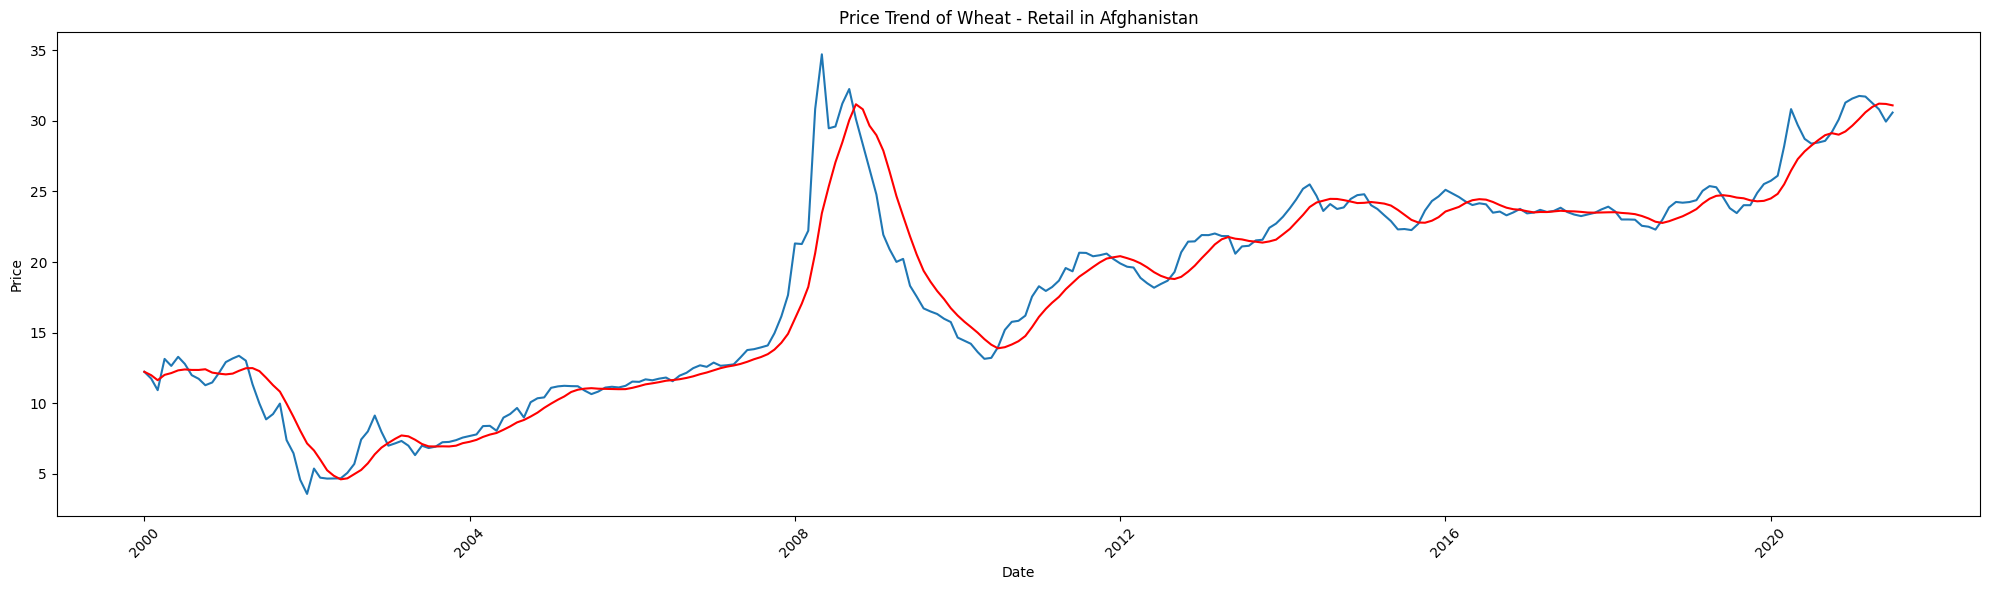

-------------> Showing the plots of trend, seasonality and residuals for the selected commodity and country <-------------


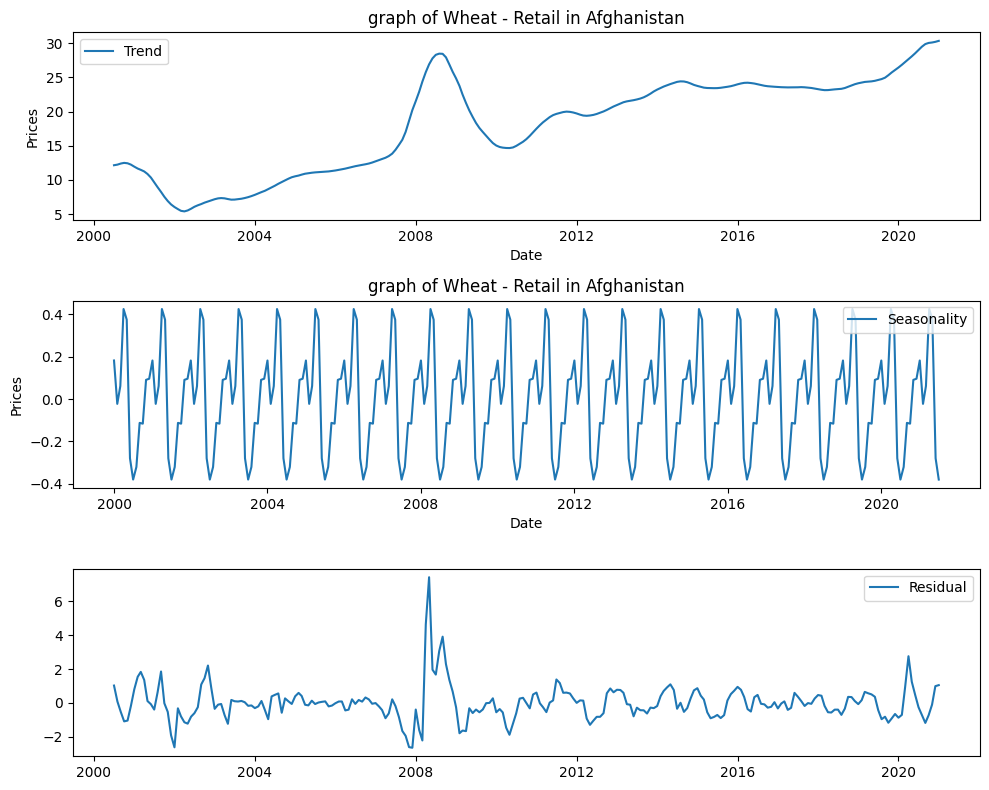

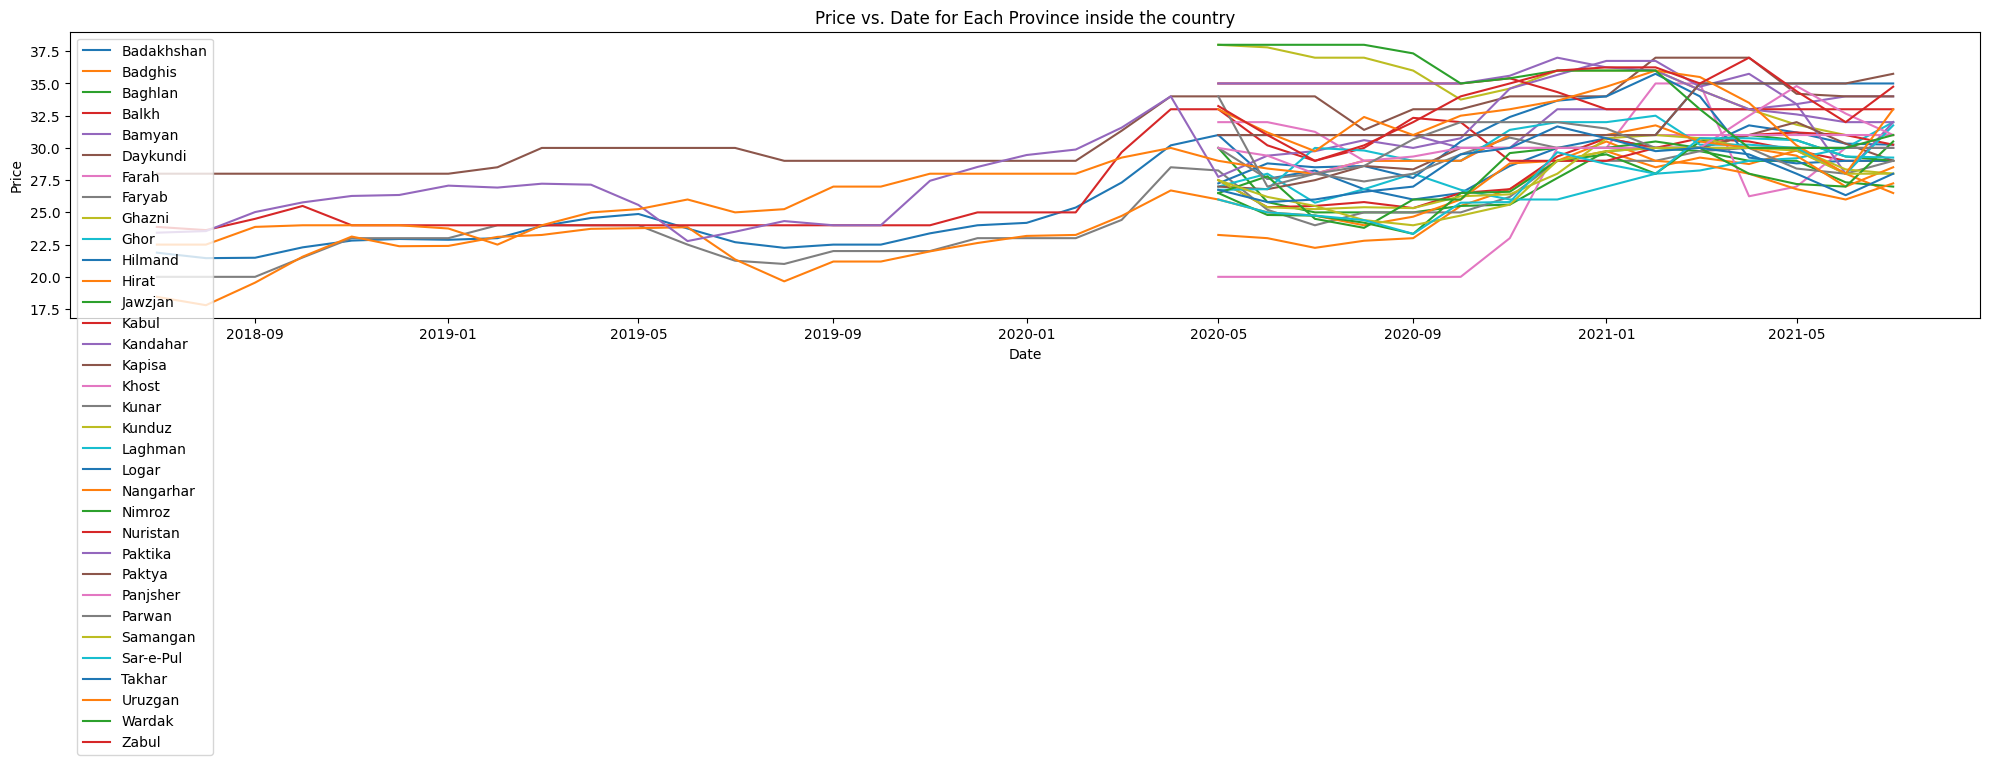

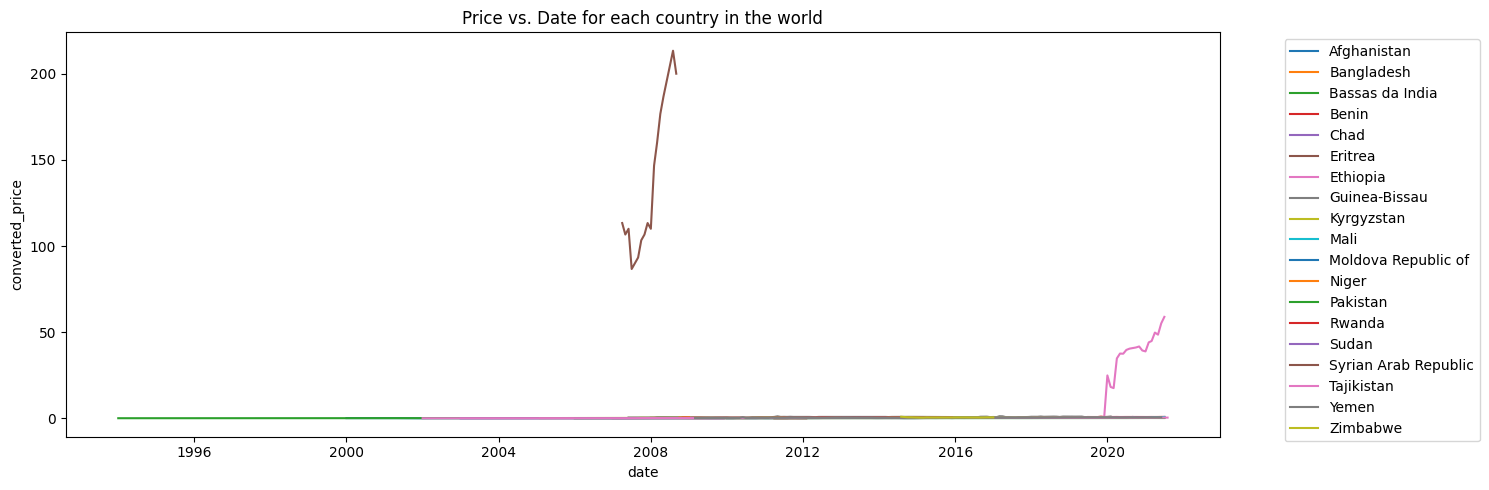

In [18]:
# Calling the class object
report = Exploration("wfpvam_foodprices.csv","currency_rates.csv",'Afghanistan', 'Wheat - Retail')
que1 = report.question_1()
que2 = report.question_2()
que3 = report.question_3()
que3_world = report.question_3_world()

Insights:
- Wheat prices in Afghanistan have risen dramatically over time. Prices are rising in a definite upward trend, with added seasonality. The graph shows a significant increase between 2008 and 2009. This is because Afghanistan's food supply network collapsed in 2008(more about this in Report.doc)
- Most of the provinces inside Afghanistan doesn't have the more historical data. For all of the provinces except 'Badakhshan', 'Daykundi', 'Faryab', 'Hirat', 'Kabul', 'Kandahar', 'Nangarhar' the data starts from the year 2020-05-01
- When compared the selected commodity world wide, only 20 countries have 'Wheat - Retail' prices. 
- The currencies of all countries are converted into USD for standardising the price
- In the plot the prices of Eritrea and Ethiopia countries are higher than other countries. It is because some of the records are entered in 100 Kilograms and also the price is calulated for 100 KG rate. This is the reason of the spike in their prices


### Advanced Analysis on the Selected Country and Selected Commodity

##### Question 2

There are several hypothesis that we can consider in order to source the selected commodity for this country.

- Countries with lower production costs will be able to offer the commodity at a lower price. Another hypothesis is that countries with higher demand for the commodity will have higher prices.<br> 
- We have to consider the transportation infrastructure, shipping costs, logistics networks etc. We can also consider the hypothesis that countries with better infrastructure and logistics will be able to offer the commodity at a lower price.<br>
- Countries with political and economic stability of potential sourcing destinations with favorable business environments, stable governments, and robust economic conditions in order to maintain healthy supplier relationships and eliminate geopolitical risks.<br>
- Consider trade agreements, preferential tariffs, and regulatory frameworks between the country of sourcing and the sourcing destinations. Evaluate the impact of trade barriers, import/export regulations, and customs procedures on the flow of commodities.<br>


In [19]:
# Filter the main df bby commodity name
wheat_df = data[data['commodity_name']== 'Wheat - Retail']

currency_df = df_currency

wheat_df['date'] = pd.to_datetime(wheat_df['year'].astype(str) + '-' + wheat_df['month'].astype(str), format='%Y-%m')

# Merge the main df with currency df on currency names
wheat_df = wheat_df.merge(currency_df[['conversion_rate', 'currency_name']], on='currency_name', how='inner')

# Change the prices by adding the new column
wheat_df['converted_price'] = wheat_df['price']/wheat_df['conversion_rate']

# Considering the previous years dates to calculate the average prices of the wheat in each country
wheat_df = wheat_df[wheat_df['date']>='2020-01-01']
wheat_df

,country_name,province_name,market_name,commodity_name,currency_name,pricetype_name,unit_of_measurement,month,year,price,date,conversion_rate,converted_price
202,Afghanistan,Badakhshan,Fayzabad,Wheat - Retail,AFN,Retail,KG,1,2020,25.37500,2020-01-01,85.10000,0.29818
203,Afghanistan,Badakhshan,Fayzabad,Wheat - Retail,AFN,Retail,KG,2,2020,26.75000,2020-02-01,85.10000,0.31434
204,Afghanistan,Badakhshan,Fayzabad,Wheat - Retail,AFN,Retail,KG,3,2020,29.05000,2020-03-01,85.10000,0.34136
205,Afghanistan,Badakhshan,Fayzabad,Wheat - Retail,AFN,Retail,KG,4,2020,31.40000,2020-04-01,85.10000,0.36898
406,Afghanistan,Badakhshan,Mazar,Wheat - Retail,AFN,Retail,KG,1,2020,23.00000,2020-01-01,85.10000,0.27027
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26656,Yemen,Raymah,Al Jabeen,Wheat - Retail,YER,Retail,KG,1,2021,235.00000,2021-01-01,511.68000,0.45927
26657,Yemen,Raymah,Al Jabeen,Wheat - Retail,YER,Retail,KG,2,2021,232.50000,2021-02-01,511.68000,0.45439
26658,Yemen,Raymah,Al Jabeen,Wheat - Retail,YER,Retail,KG,3,2021,250.50000,2021-03-01,511.68000,0.48956
26659,Yemen,Raymah,Al Jabeen,Wheat - Retail,YER,Retail,KG,4,2021,240.00000,2021-04-01,511.68000,0.46904


-------------> Showing the plot comparing the selected commodity through out the world <-------------


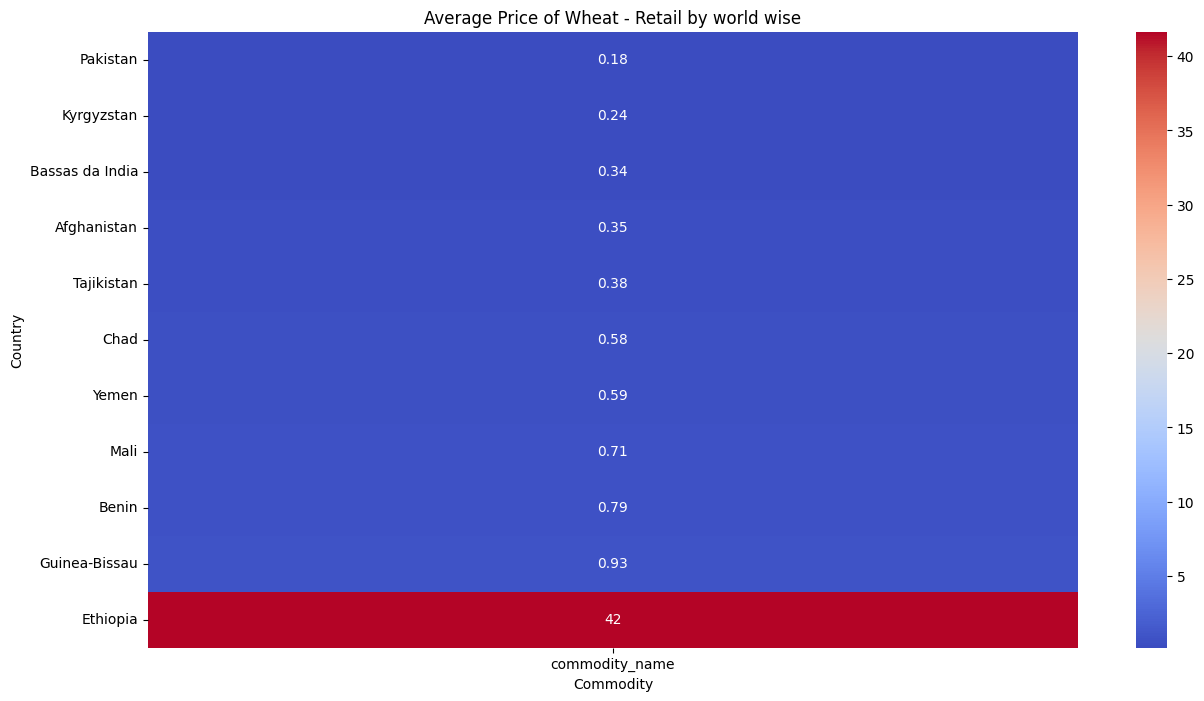

In [20]:
pivot_table = pd.pivot_table(wheat_df, values='converted_price', index=['country_name'], columns=['commodity_name'], aggfunc=np.mean)
pivot_table.columns.name = None

# change the column names and sort the column values by ascending order
pivot_table = pivot_table.rename(columns={'Wheat - Retail': 'commodity_name'}).sort_values(by='commodity_name')

# Set the plot size
plt.figure(figsize=(15, 8))

# Create the heatmap
sns.heatmap(pivot_table, cmap='coolwarm', annot=True)

# Set the title and labels
plt.title(f'Average Price of Wheat - Retail by world wise')
plt.xlabel('Commodity')
plt.ylabel('Country')

# Show the plot
print("-------------> Showing the plot comparing the selected commodity through out the world <-------------")
plt.show()

# # Save the plot to the specific folder
# file_path = os.path.join(output_dir, 'compare_avg_prices_plot.png') 
# plt.savefig(file_path)


- These are the countries with the average prices of the wheat in each country since 2020-01-01. 
- The values are sorted in ascending order lowest to highest avg prices of wheat. 
- From the graph the lowest prices are the in the countries like pakistan, kyrgyzstan etc.. 
- From the graph Ethiopia has the highest avg price of wheat which is 42 USD.
- But in reality the actual price of wheat in Ethiopia is between US$ 0.5 and US$ 1.3 per kilogram from this website
https://www.selinawamucii.com/insights/prices/ethiopia/wheat-flour/ 
- This change in price is because the unit of measurements in ethiopia country is in 100 kilograms. 
- Finally, by keeping in mind all the hypothesis I mentioned before,If I have relevant data availability to conduct a comprehensive analysis of factors influencing commodity prices, such as production levels, import/export data, geopolitical factors, and market conditions we can make a trade off and decide the best country to source from.

In [21]:
wheat_df[wheat_df['country_name']=='Ethiopia']

,country_name,province_name,market_name,commodity_name,currency_name,pricetype_name,unit_of_measurement,month,year,price,date,conversion_rate,converted_price
18398,Ethiopia,SNNPR,Hossana,Wheat - Retail,ETB,Retail,100 KG,4,2020,1630.00000,2020-04-01,54.66000,29.82071
18399,Ethiopia,SNNPR,Hossana,Wheat - Retail,ETB,Retail,100 KG,6,2020,1955.00000,2020-06-01,54.66000,35.76656
18400,Ethiopia,SNNPR,Hossana,Wheat - Retail,ETB,Retail,100 KG,7,2020,2100.00000,2020-07-01,54.66000,38.41932
18401,Ethiopia,SNNPR,Hossana,Wheat - Retail,ETB,Retail,100 KG,11,2020,1900.00000,2020-11-01,54.66000,34.76034
18402,Ethiopia,SNNPR,Hossana,Wheat - Retail,ETB,Retail,100 KG,12,2020,1735.00000,2020-12-01,54.66000,31.74168
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19059,Ethiopia,Tigray,Adwa,Wheat - Retail,ETB,Retail,KG,2,2020,17.90000,2020-02-01,54.66000,0.32748
19060,Ethiopia,Tigray,Adwa,Wheat - Retail,ETB,Retail,KG,3,2020,17.92000,2020-03-01,54.66000,0.32784
19363,Ethiopia,Oromia,Yabelo,Wheat - Retail,ETB,Retail,KG,1,2020,16.50000,2020-01-01,54.66000,0.30187
19364,Ethiopia,Oromia,Yabelo,Wheat - Retail,ETB,Retail,KG,2,2020,16.00000,2020-02-01,54.66000,0.29272


##### Question 1

- To know the trend, seasonality and forecast for next 12 months we have to subset the country and commodity from the main dataframe
- We can forecast by the level of granualarity we choose. I chose Province level forecasting over Country level and Market level analysis


In [22]:
# Subsetting the data frame by required country name and commodity 
df_afghan = data[(data.country_name=='Afghanistan')&(data.commodity_name=='Wheat - Retail')]
df_afghan.reset_index(drop=True, inplace=True)
df_afghan

,country_name,province_name,market_name,commodity_name,currency_name,pricetype_name,unit_of_measurement,month,year,price
0,Afghanistan,Badakhshan,Fayzabad,Wheat - Retail,AFN,Retail,KG,1,2003,7.00000
1,Afghanistan,Badakhshan,Fayzabad,Wheat - Retail,AFN,Retail,KG,2,2003,6.00000
2,Afghanistan,Badakhshan,Fayzabad,Wheat - Retail,AFN,Retail,KG,3,2003,7.00000
3,Afghanistan,Badakhshan,Fayzabad,Wheat - Retail,AFN,Retail,KG,4,2003,6.00000
4,Afghanistan,Badakhshan,Fayzabad,Wheat - Retail,AFN,Retail,KG,5,2003,6.00000
...,...,...,...,...,...,...,...,...,...,...
2307,Afghanistan,Panjsher,Panjsher,Wheat - Retail,AFN,Retail,KG,3,2021,30.00000
2308,Afghanistan,Panjsher,Panjsher,Wheat - Retail,AFN,Retail,KG,4,2021,32.50000
2309,Afghanistan,Panjsher,Panjsher,Wheat - Retail,AFN,Retail,KG,5,2021,34.80000
2310,Afghanistan,Panjsher,Panjsher,Wheat - Retail,AFN,Retail,KG,6,2021,32.66670


In [23]:
# Checking for null values in afghan dataframe
df_afghan.isnull().sum()

#There are no null values

country_name           0
province_name          0
market_name            0
commodity_name         0
currency_name          0
pricetype_name         0
unit_of_measurement    0
month                  0
year                   0
price                  0
dtype: int64

In [24]:
# Check the number of provinces in the selected country
df_afghan.province_name.unique()

# There are 34 provinces in this country data

array(['Badakhshan', 'Badghis', 'Baghlan', 'Balkh', 'Bamyan', 'Farah',
       'Faryab', 'Ghazni', 'Ghor', 'Hilmand', 'Hirat', 'Jawzjan', 'Kabul',
       'Kandahar', 'Kapisa', 'Khost', 'Kunar', 'Kunduz', 'Laghman',
       'Logar', 'Nangarhar', 'Nimroz', 'Nuristan', 'Paktika', 'Paktya',
       'Parwan', 'Samangan', 'Sar-e-Pul', 'Takhar', 'Uruzgan', 'Wardak',
       'Zabul', 'Daykundi', 'Panjsher'], dtype=object)

In [25]:
# Combine month and year columns into a new 'date' column
df_afghan['date'] = pd.to_datetime(df_afghan['year'].astype(str) + '-' + df_afghan['month'].astype(str), format='%Y-%m')
df_afghan

,country_name,province_name,market_name,commodity_name,currency_name,pricetype_name,unit_of_measurement,month,year,price,date
0,Afghanistan,Badakhshan,Fayzabad,Wheat - Retail,AFN,Retail,KG,1,2003,7.00000,2003-01-01
1,Afghanistan,Badakhshan,Fayzabad,Wheat - Retail,AFN,Retail,KG,2,2003,6.00000,2003-02-01
2,Afghanistan,Badakhshan,Fayzabad,Wheat - Retail,AFN,Retail,KG,3,2003,7.00000,2003-03-01
3,Afghanistan,Badakhshan,Fayzabad,Wheat - Retail,AFN,Retail,KG,4,2003,6.00000,2003-04-01
4,Afghanistan,Badakhshan,Fayzabad,Wheat - Retail,AFN,Retail,KG,5,2003,6.00000,2003-05-01
...,...,...,...,...,...,...,...,...,...,...,...
2307,Afghanistan,Panjsher,Panjsher,Wheat - Retail,AFN,Retail,KG,3,2021,30.00000,2021-03-01
2308,Afghanistan,Panjsher,Panjsher,Wheat - Retail,AFN,Retail,KG,4,2021,32.50000,2021-04-01
2309,Afghanistan,Panjsher,Panjsher,Wheat - Retail,AFN,Retail,KG,5,2021,34.80000,2021-05-01
2310,Afghanistan,Panjsher,Panjsher,Wheat - Retail,AFN,Retail,KG,6,2021,32.66670,2021-06-01


In [26]:
# Generate a complete monthly date range
min_month_year = df_afghan['date'].min()
max_month_year = df_afghan['date'].max()
date_range = pd.date_range(start=min_month_year, end=max_month_year, freq='MS')

# Find missing months and years
missing_months_years = date_range[~date_range.isin(df_afghan['date'])]
missing_months = missing_months_years.month
missing_years = missing_months_years.year

# Print the missing months and years
if len(missing_months_years) > 0:
    print("Missing Months and Years:")
    for month, year in zip(missing_months, missing_years):
        print(f"Month: {month}, Year: {year}")
else:
    print("No missing months and years found.")


Missing Months and Years:
Month: 2, Year: 2016


In [27]:
# Filtering the dataframe to check if there is any data on the missing date
df_afghan[df_afghan['date']=='2016-02-01']

,country_name,province_name,market_name,commodity_name,currency_name,pricetype_name,unit_of_measurement,month,year,price,date


In [28]:
# Province level Forecasting
# Grouping by provinces and dates getting the mean of prices on each date
df_afghan_province = df_afghan.groupby(['province_name','date'], as_index=False)['price'].mean()
df_afghan_province

,province_name,date,price
0,Badakhshan,2003-01-01,7.00000
1,Badakhshan,2003-02-01,6.50000
2,Badakhshan,2003-03-01,7.00000
3,Badakhshan,2003-04-01,6.50000
4,Badakhshan,2003-05-01,5.50000
...,...,...,...
2103,Zabul,2021-03-01,35.00000
2104,Zabul,2021-04-01,37.00000
2105,Zabul,2021-05-01,34.40000
2106,Zabul,2021-06-01,32.00000


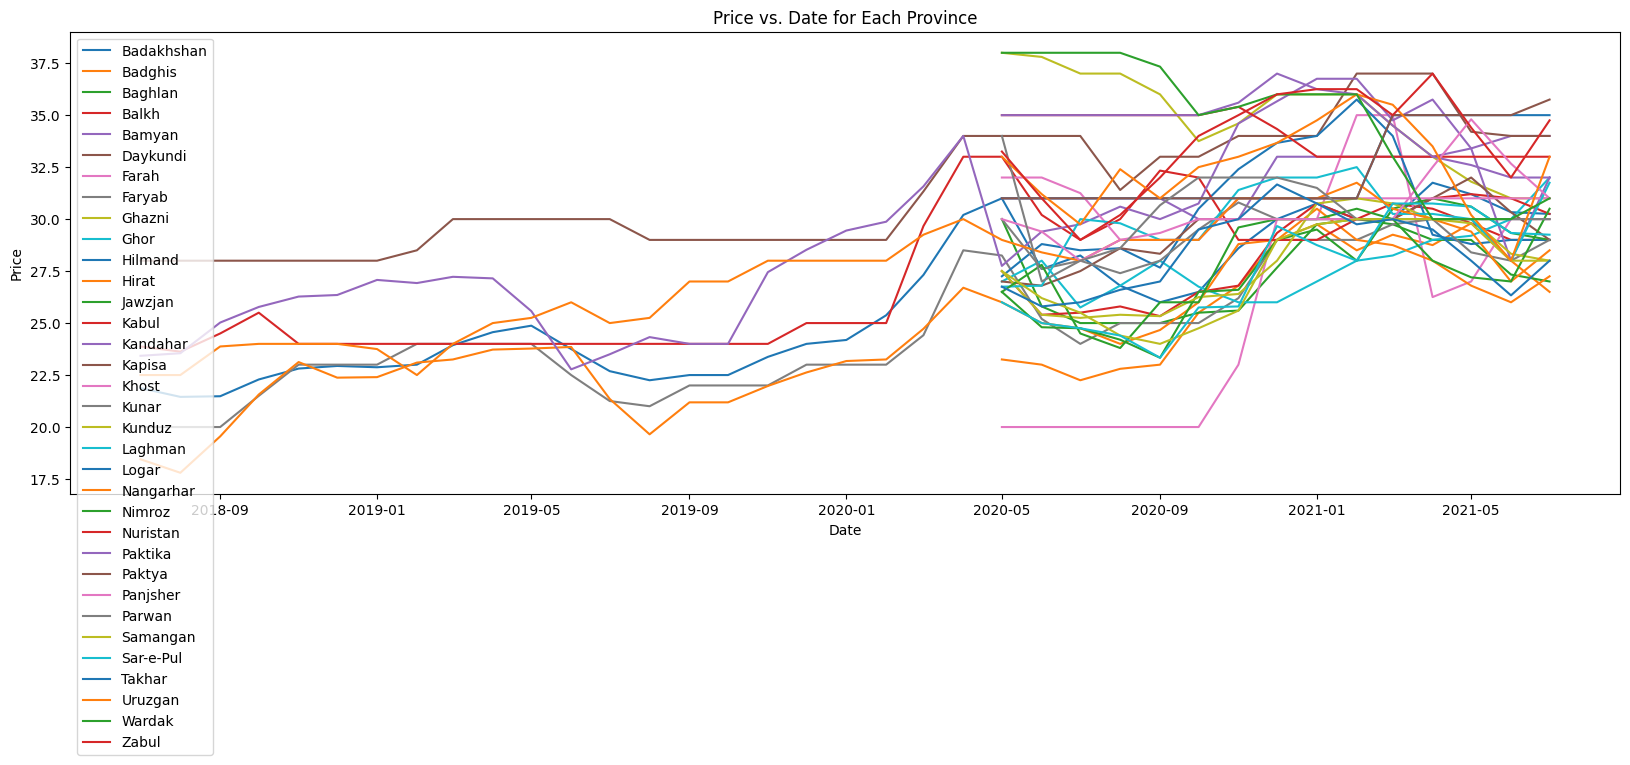

In [29]:

# Group the DataFrame by province
grouped_df = df_afghan_province.groupby('province_name')

# Set the figure size
plt.figure(figsize=(20, 6))  

# Calculate the start date for the last five years
end_date = df_afghan_province['date'].max()
start_date = end_date - pd.DateOffset(years=3)

# Iterate over each province group
for province, group in grouped_df:
    # Set the 'date' column as the index
    group.set_index('date', inplace=True)
    
    # Filter the data for the last five years
    filtered_group = group.loc[start_date:end_date]
    
    # Plot the prices for the province
    plt.plot(filtered_group.index, filtered_group['price'], label=province)

# Add labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price vs. Date for Each Province')
plt.legend()

# Display the plot
plt.show()
# # Save the plot to the specific folder
# file_path = os.path.join(output_dir, 'afg_provinces_plot.png') 
# plt.savefig(file_path)



. From the graph we can see that most of the provinces doesn't have enough historical data for forecasting<br>
. So I am considering the provinces which have most years of data for my forecasting to acquire better predictions and obtain efficient results<br>

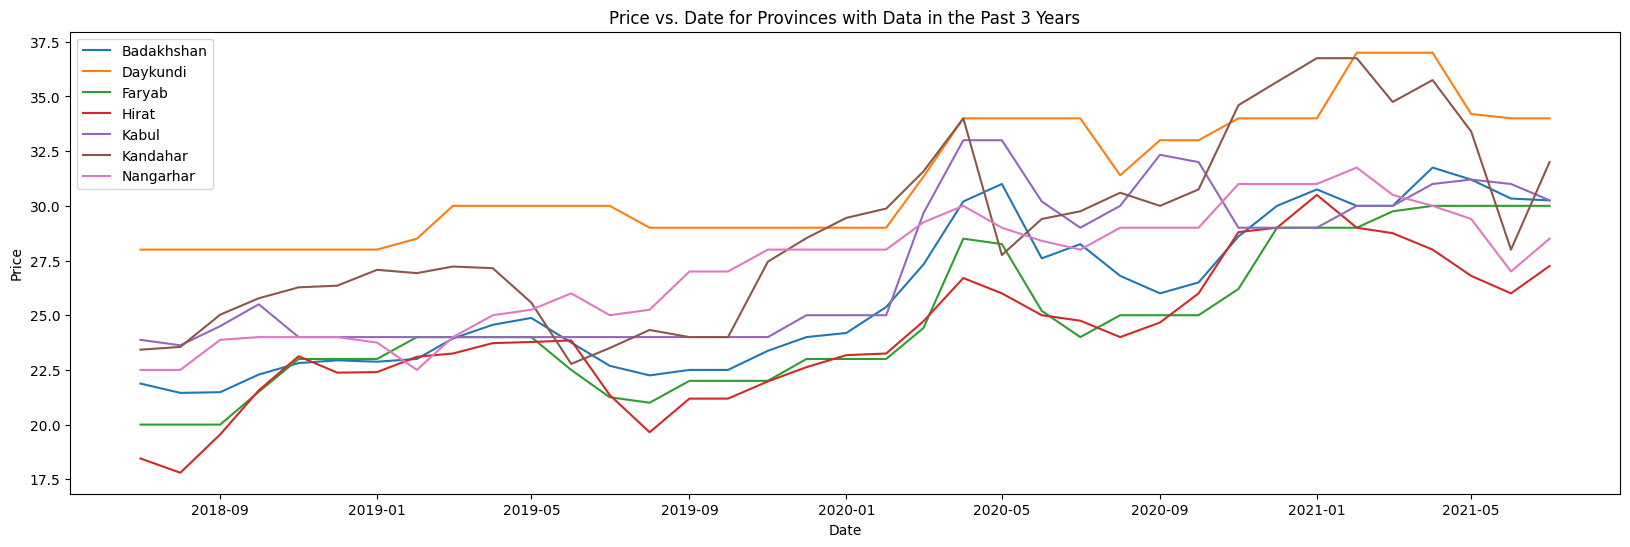

In [30]:
# Group the DataFrame by province
grouped_df = df_afghan_province.groupby('province_name')

# Set the figure size
plt.figure(figsize=(20, 6))  

# Calculate the start date for the past three years
end_date = df_afghan_province['date'].max()
start_date = end_date - pd.DateOffset(years=3)

# Iterate over each province group
for province, group in grouped_df:
    # Set the 'date' column as the index
    group.set_index('date', inplace=True)
    
    # Filter the data for the past three years
    filtered_group = group.loc[start_date:end_date]
    
    # Check if the filtered group has data for at least three years
    if len(filtered_group) >= 36:  # Assuming monthly data (12 months * 3 years = 36)
        # Plot the prices for the province
        plt.plot(filtered_group.index, filtered_group['price'], label=province)

# Add labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price vs. Date for Provinces with Data in the Past 3 Years')
plt.legend()

# Display the plot
plt.show()
# # Save the plot to the specific folder
# file_path = os.path.join(output_dir, 'provinces_past3_plot.png') 
# plt.savefig(file_path)
# plt.close()

In [31]:
# List of the final provinces to keep
provinces_to_keep = ['Badakhshan', 'Daykundi', 'Faryab', 'Hirat', 'Kabul', 'Kandahar', 'Nangarhar']

# Filter the DataFrame to keep only the rows for the desired provinces
filtered_df = df_afghan_province[df_afghan_province['province_name'].isin(provinces_to_keep)]

# Display the filtered DataFrame
filtered_df

,province_name,date,price
0,Badakhshan,2003-01-01,7.00000
1,Badakhshan,2003-02-01,6.50000
2,Badakhshan,2003-03-01,7.00000
3,Badakhshan,2003-04-01,6.50000
4,Badakhshan,2003-05-01,5.50000
...,...,...,...
1904,Nangarhar,2021-03-01,30.50000
1905,Nangarhar,2021-04-01,30.00000
1906,Nangarhar,2021-05-01,29.40000
1907,Nangarhar,2021-06-01,27.00000


In [32]:
# Group by province and calculate the minimum and maximum dates
province_dates = filtered_df.groupby('province_name')['date'].agg(['min', 'max'])
province_dates['diff'] = province_dates['max'] - province_dates['min']
print(province_dates)

                     min        max      diff
province_name                                
Badakhshan    2003-01-01 2021-07-01 6756 days
Daykundi      2006-08-01 2021-07-01 5448 days
Faryab        2004-03-01 2021-07-01 6331 days
Hirat         2000-01-01 2021-07-01 7852 days
Kabul         2000-01-01 2021-07-01 7852 days
Kandahar      2000-01-01 2021-07-01 7852 days
Nangarhar     2000-01-01 2021-07-01 7852 days


In [33]:
# Find missing dates for each province
missing_dates = {}
for province, dates in province_dates.iterrows():
    min_date = dates['min']
    max_date = dates['max']
    
    # Create a complete date range
    complete_date_range = pd.date_range(start=min_date, end=max_date, freq='MS')
    
    # Find missing dates by comparing with actual dates
    missing = set(complete_date_range) - set(filtered_df.loc[filtered_df['province_name'] == province, 'date'])
    
    # Store missing dates and their count in a dictionary
    missing_dates[province] = {'missing': len(missing) > 0, 'count': len(missing), 'Actual': len(complete_date_range),'start_date':min_date, 'end_date':max_date }

missing_dates

for province, values in missing_dates.items():
    if values['missing']:
        print(f"Missing dates are in Province: {province}, Total Months: {values['Actual']} months, Missing Months: {values['count']} months ")


Missing dates are in Province: Badakhshan, Total Months: 223 months, Missing Months: 2 months 
Missing dates are in Province: Daykundi, Total Months: 180 months, Missing Months: 7 months 
Missing dates are in Province: Faryab, Total Months: 209 months, Missing Months: 7 months 
Missing dates are in Province: Hirat, Total Months: 259 months, Missing Months: 1 months 
Missing dates are in Province: Kabul, Total Months: 259 months, Missing Months: 1 months 
Missing dates are in Province: Kandahar, Total Months: 259 months, Missing Months: 4 months 
Missing dates are in Province: Nangarhar, Total Months: 259 months, Missing Months: 1 months 


- For the provinces with missing data we will impute the data by filling the missing values by interpolation
- For building a time series forecasting model, We have to make the data stationary 
- In order to do that we perform Augumented dickey fuller test to check the stationarity of our data
- Null hypothesis - Data is not stationary, Alternate hypothesis - Data is stationary
- if p-value is less than 0.05 we reject the null hypothesis, i,e our data is stationary data or else we have to remove the seasonality, trend in the data by differencing.
- We check the decomposition of the data by plotting them to check the trend, seasonality and residuals of our data.
- After that we plot the auto correlation and partial auto correlation graphs for auto regression (p), moving average(q), differention(d) values
- ARIMA model is used to with 80% confidence interval for plotting the forecasts of the next 12 months.


Dickey-Fuller test results for Badakhshan:
Time Period: 2003-01-01 00:00:00 to 2021-07-01 00:00:00
ADF Statistic: -1.9281556201557084
p-value: 0.31893392009443955
Critical Values:
	1%: -3.461429147102264
	5%: -2.875206950587861
	10%: -2.5740544497344002

 Data is not Stationary
****************************************************************
Dickey-Fuller test results for Daykundi:
Time Period: 2006-08-01 00:00:00 to 2021-07-01 00:00:00
ADF Statistic: -2.946027332361399
p-value: 0.0402514986501745
Critical Values:
	1%: -3.4698858990744115
	5%: -2.8789026251889647
	10%: -2.5760266680839004

 Data is Stationary
****************************************************************
Dickey-Fuller test results for Faryab:
Time Period: 2004-03-01 00:00:00 to 2021-07-01 00:00:00
ADF Statistic: -2.2612676125169013
p-value: 0.18476427537447293
Critical Values:
	1%: -3.4638151713286316
	5%: -2.876250632135043
	10%: -2.574611347821651

 Data is not Stationary
*******************************************

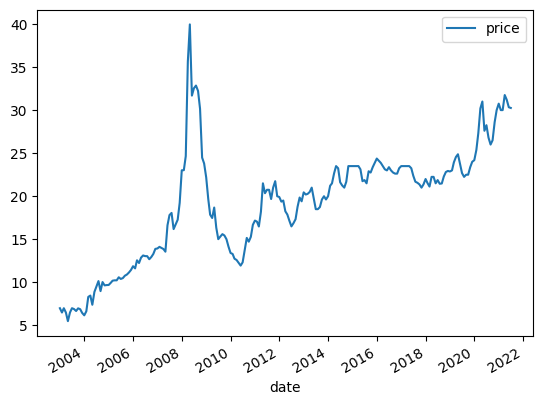

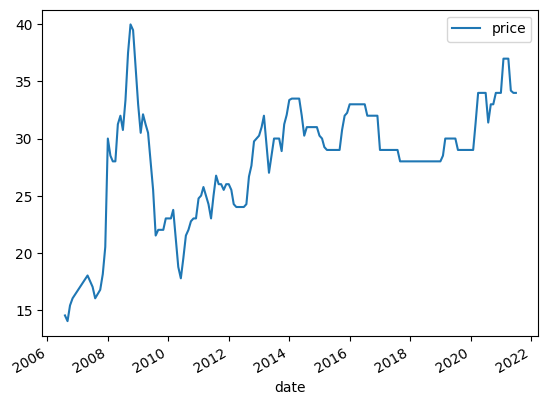

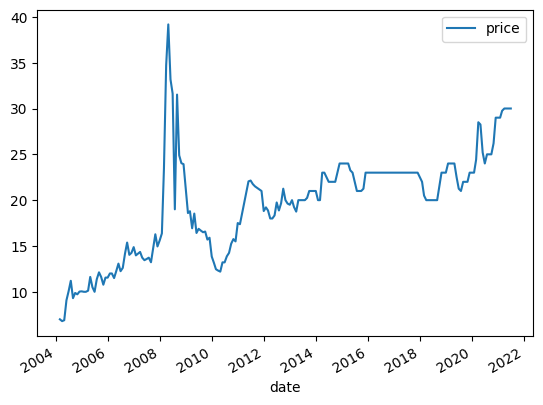

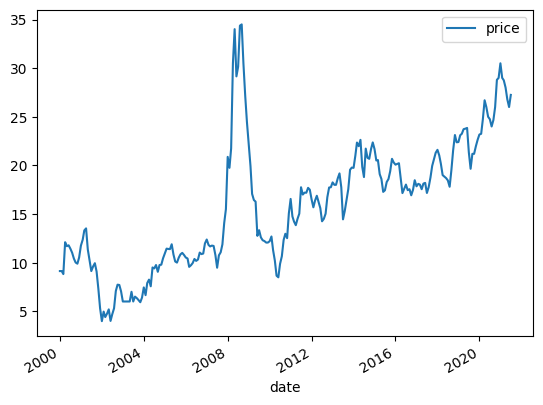

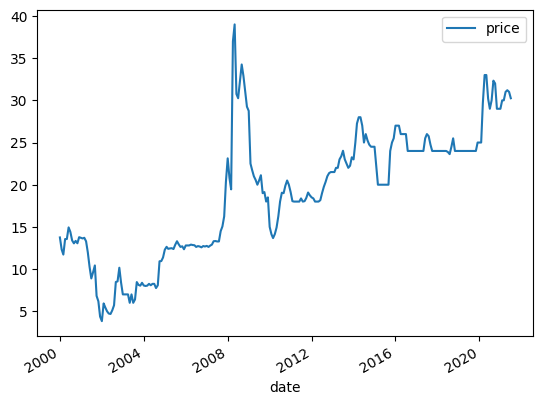

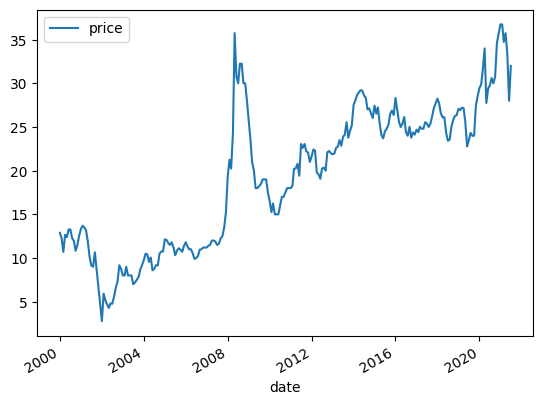

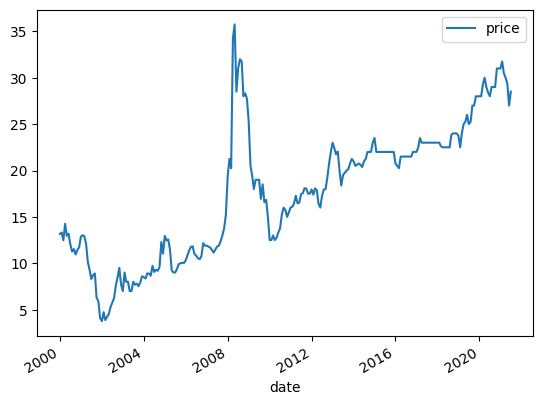

In [34]:
# Create an empty dictionary to store the test results for each province
test_results = {}

# Iterate over each province
for province in province_dates.index:
    province_df = df_afghan_province[df_afghan_province['province_name'] == province].set_index('date')  # Subset the DataFrame by province and set 'date' as the index
    province_df = province_df.drop('province_name', axis=1)
    province_df = province_df.interpolate()

    # Perform the Dickey-Fuller test on the price column of the province DataFrame
    result = adfuller(province_df['price'])
    
    # Store the test results in the dictionary
    test_results[province] = {
        'Min Date': province_df.index.min(),
        'Max Date': province_df.index.max(),
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4],
        'Plot': province_df.plot()
    }

# Print the test results for each province
for province, results in test_results.items():
    print(f"Dickey-Fuller test results for {province}:")
    print(f"Time Period: {results['Min Date']} to {results['Max Date']}")
    print(f"ADF Statistic: {results['ADF Statistic']}")
    print(f"p-value: {results['p-value']}")
    print("Critical Values:")
    for key, value in results['Critical Values'].items():
        print(f"\t{key}: {value}")
    print()
    if results['p-value']>0.05:
        print(" Data is not Stationary")
    else:
        print(" Data is Stationary")
    print("****************************************************************")
    
    # Show the line plots for each province
    #plt.title(f"Province level price plot for {province}")
    
plt.show()

Question 3

<Figure size 2000x600 with 0 Axes>

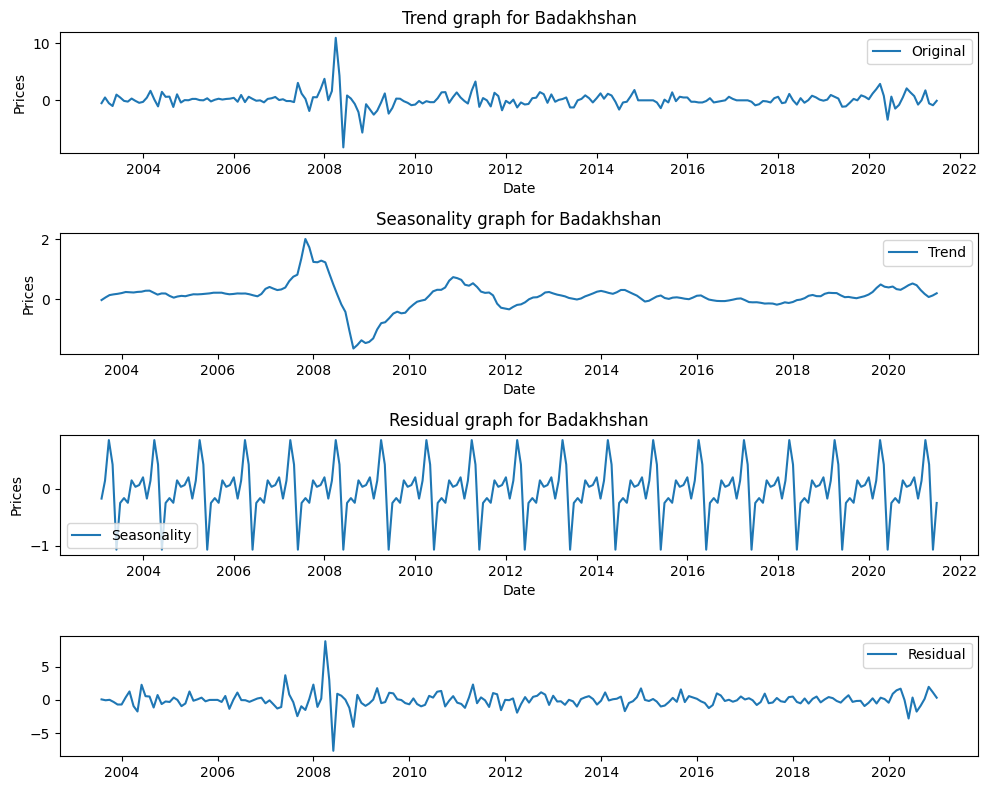

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=760.714, Time=1.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=778.928, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=772.935, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=766.234, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=759.685, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=758.438, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=758.552, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=758.985, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=756.779, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=752.777, Time=0.20 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=754.733, Time=0.37 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=754.725, Time=0.23 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=755.432, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=758.377, Time=0.24 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=754.1

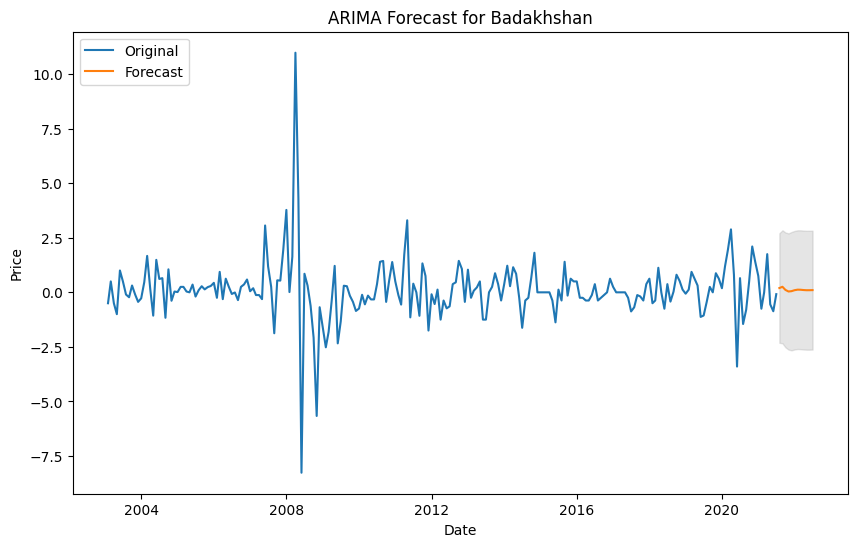

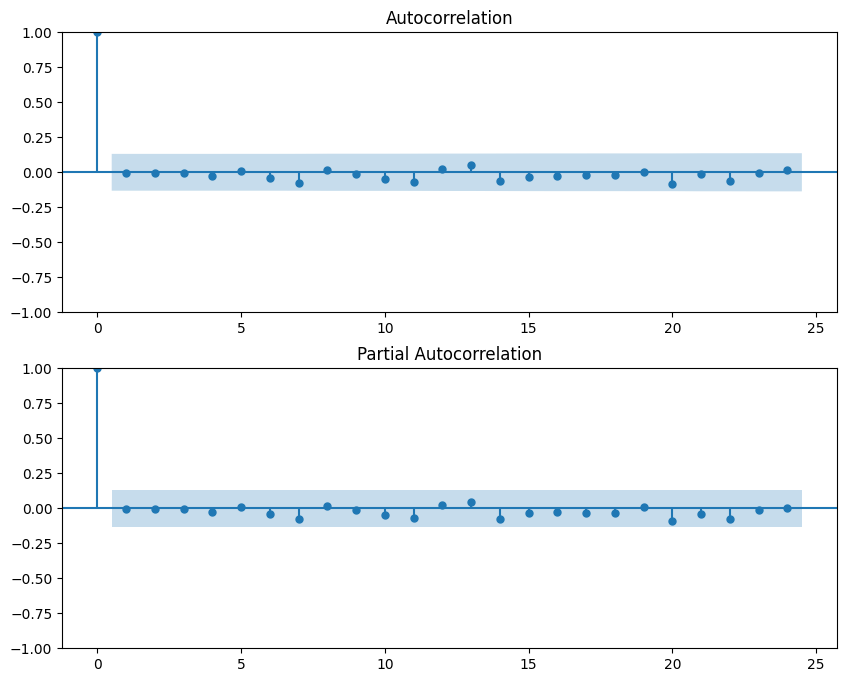

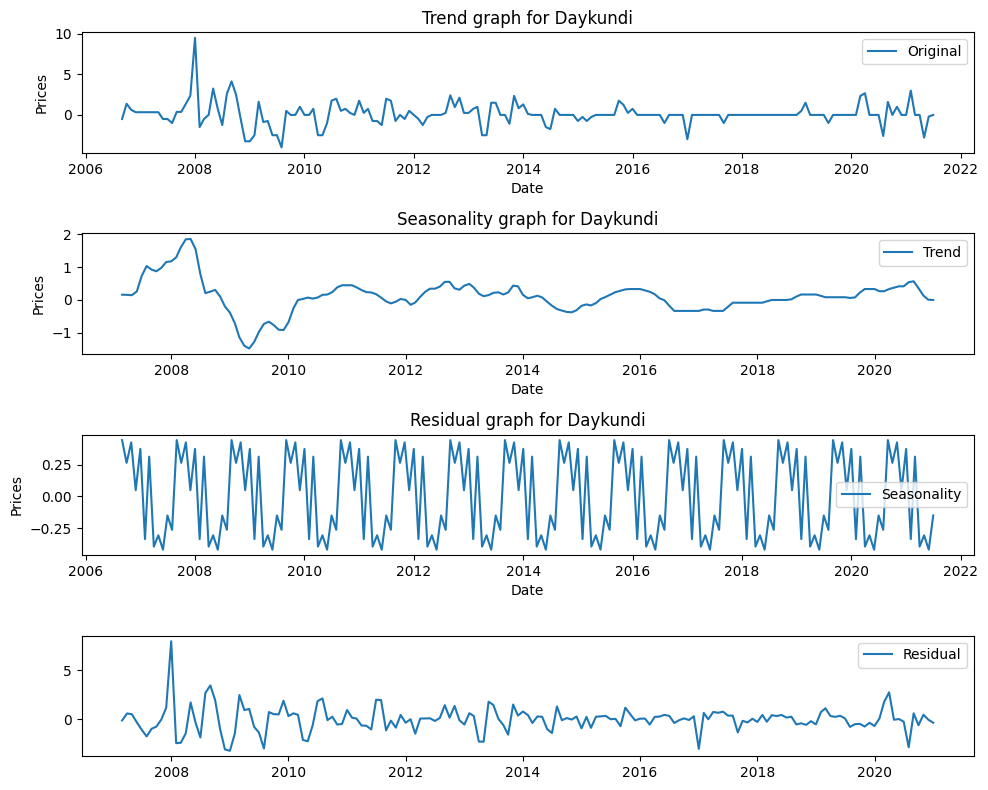

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=621.096, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=631.857, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=621.016, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=621.350, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=622.397, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=622.706, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=623.850, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=622.396, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.430 seconds
**************************** P,D,Q values for Daykundi************************


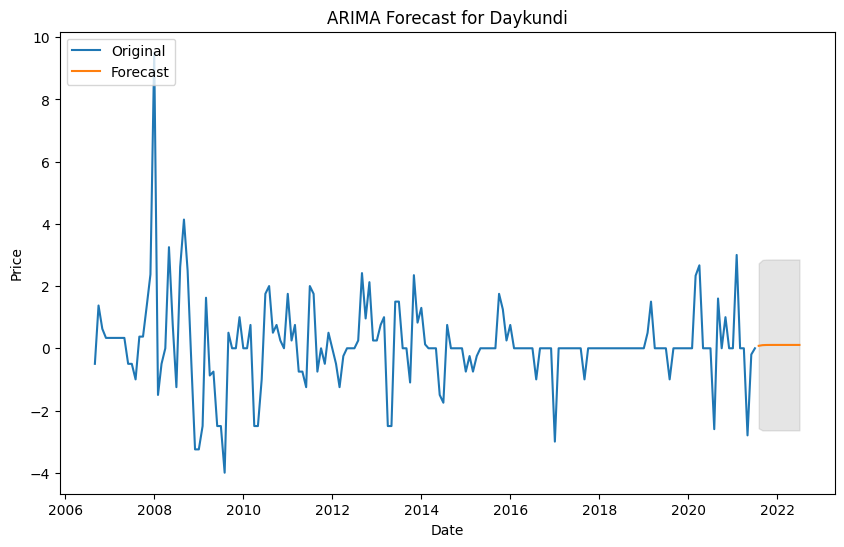

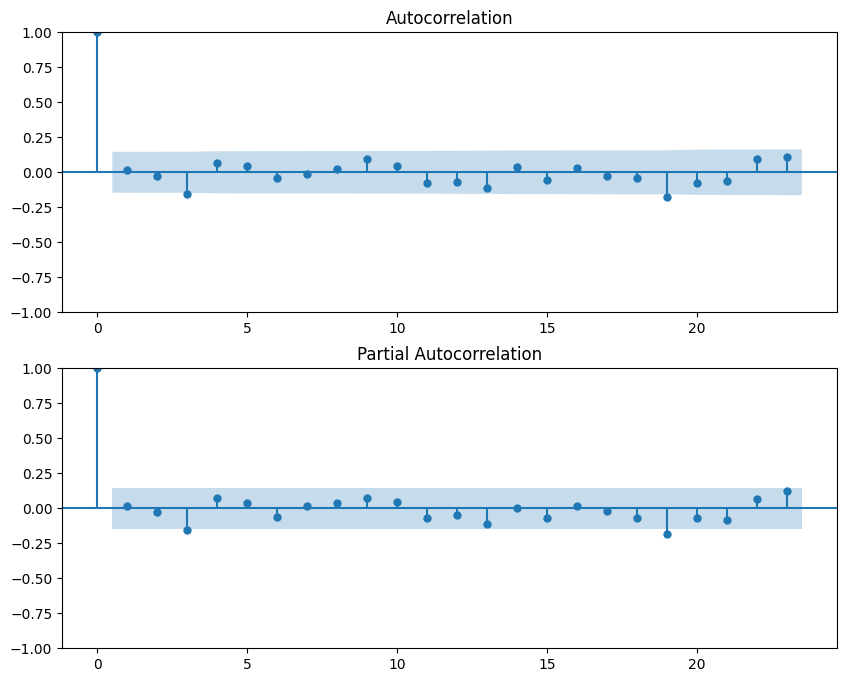

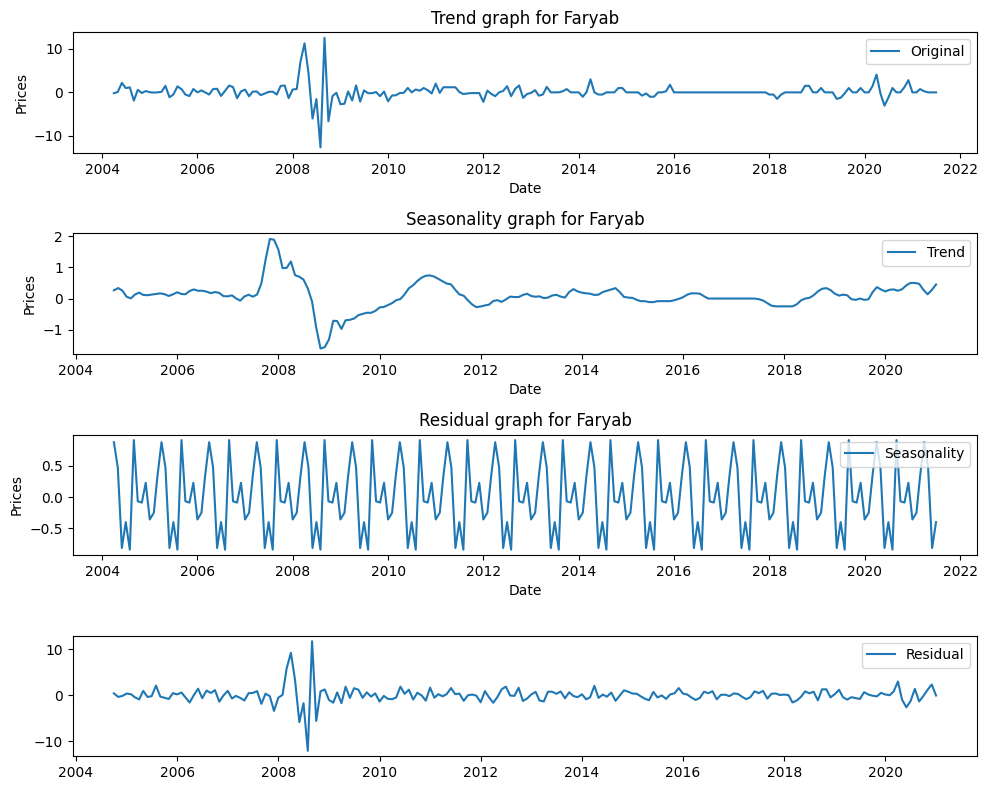

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=854.720, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=863.415, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=863.278, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=863.628, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=862.091, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=863.068, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=858.342, Time=0.23 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=857.496, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=861.651, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=856.111, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=859.521, Time=0.13 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=853.864, Time=0.61 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=856.178, Time=0.83 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=inf, Time=0.86 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=857.512, 

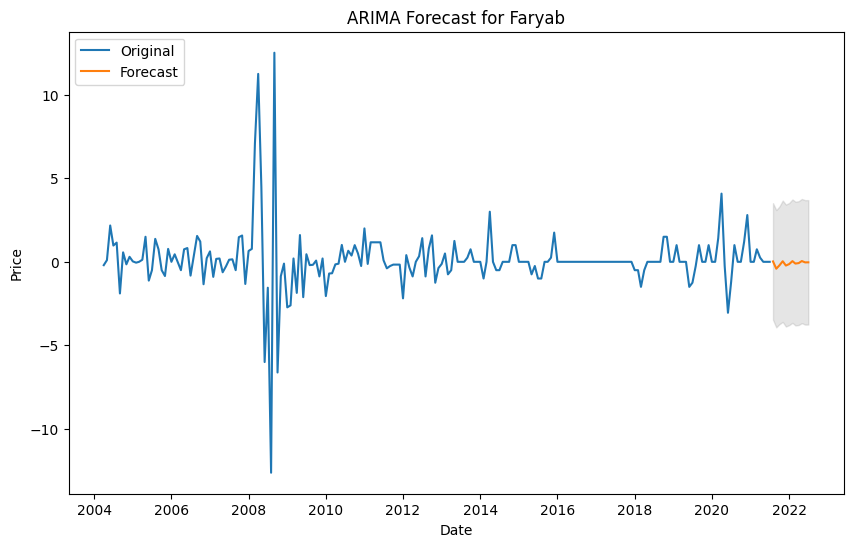

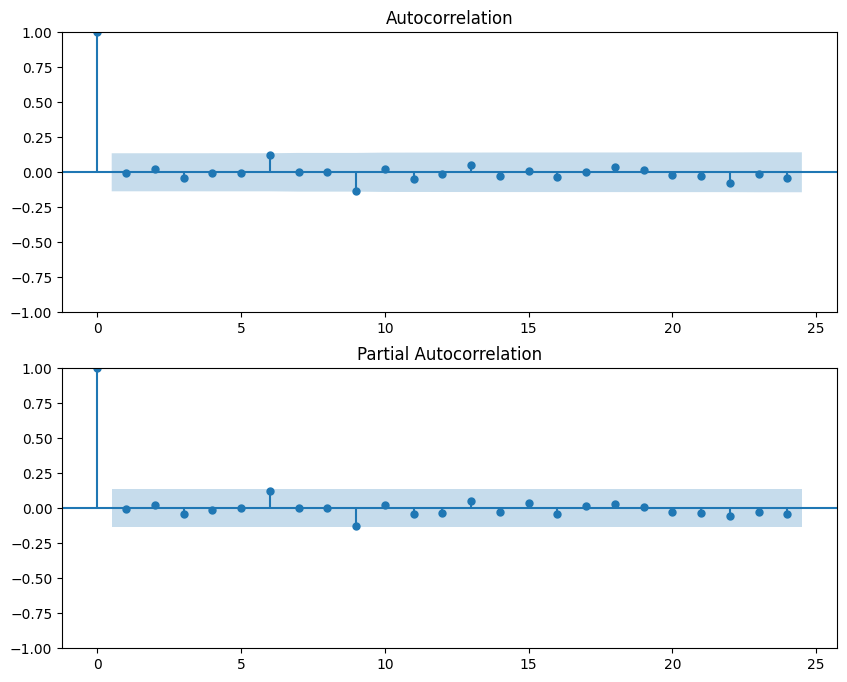

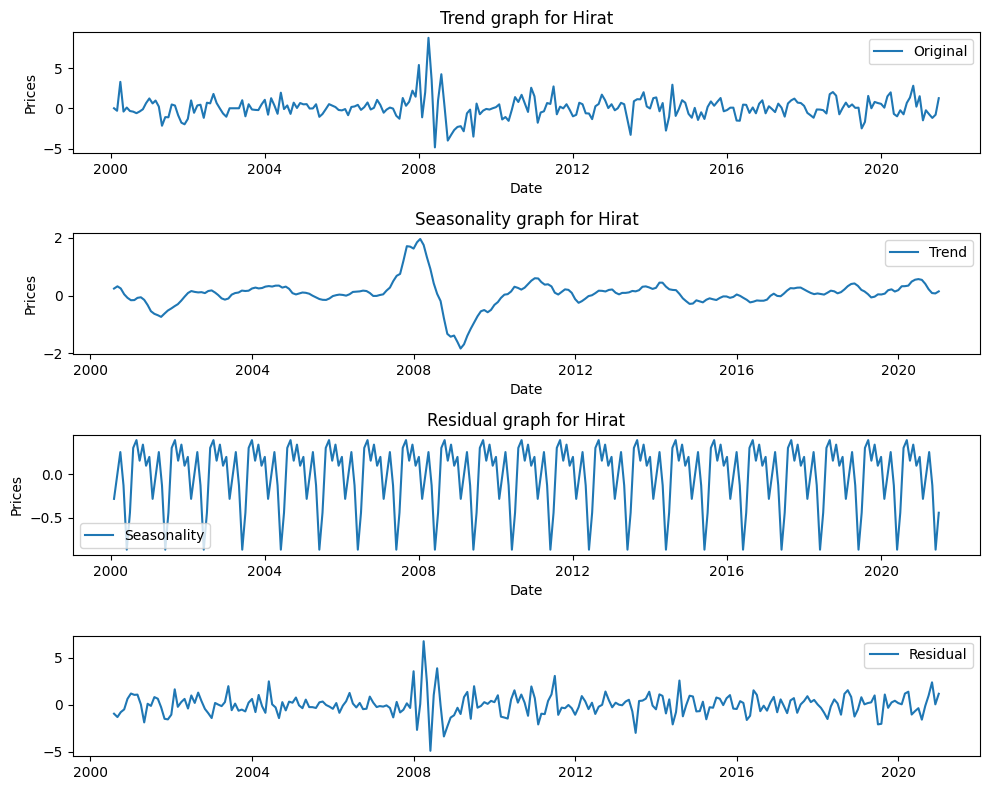

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=868.232, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=886.948, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=872.062, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=865.758, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=864.975, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=866.834, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=866.915, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=865.183, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=869.641, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=866.433, Time=0.10 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.652 seconds
**************************** P,D,Q values for Hirat************************


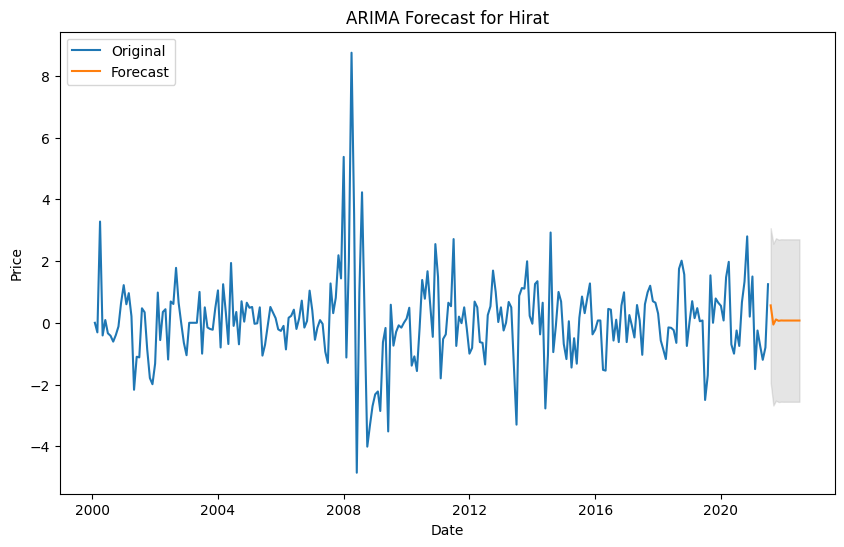

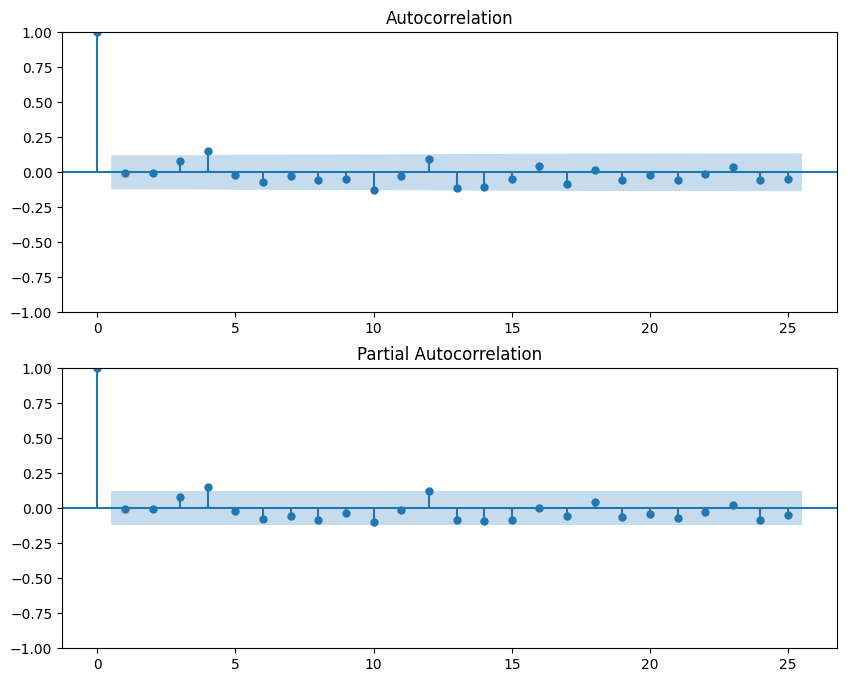

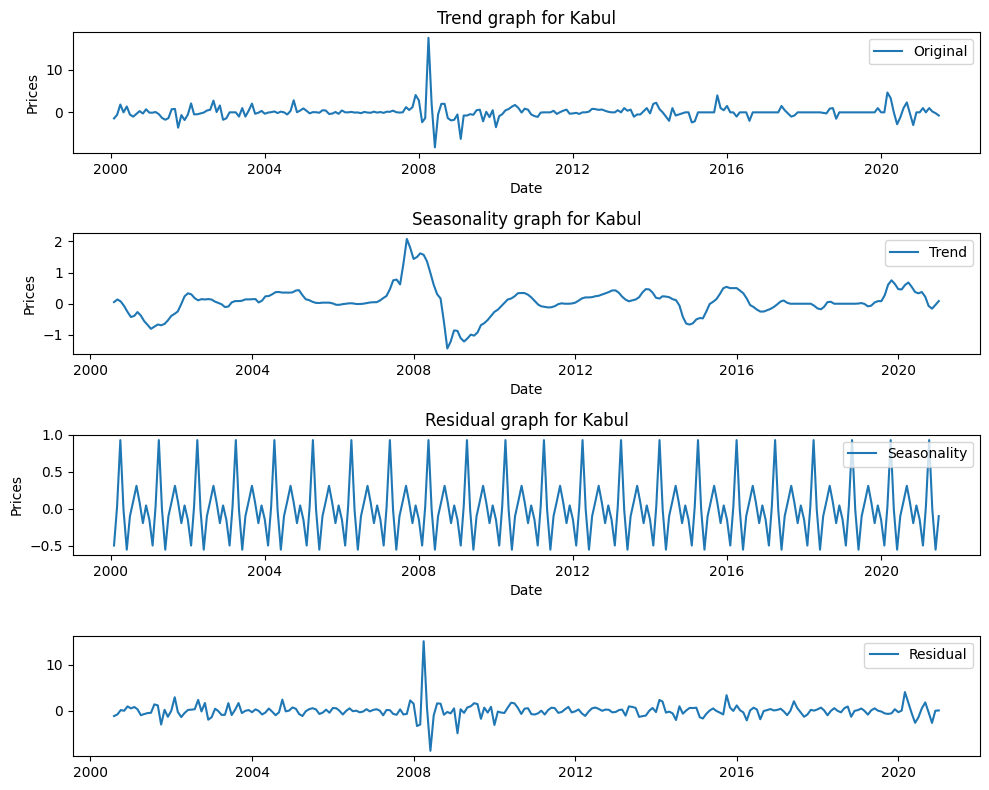

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=968.122, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=993.746, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=992.399, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=987.162, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=972.578, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=968.016, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=971.886, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=968.261, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=965.078, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=966.463, Time=0.05 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=965.971, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=965.354, Time=0.16 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=964.893, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=965.388, Time=0.12 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=957.6

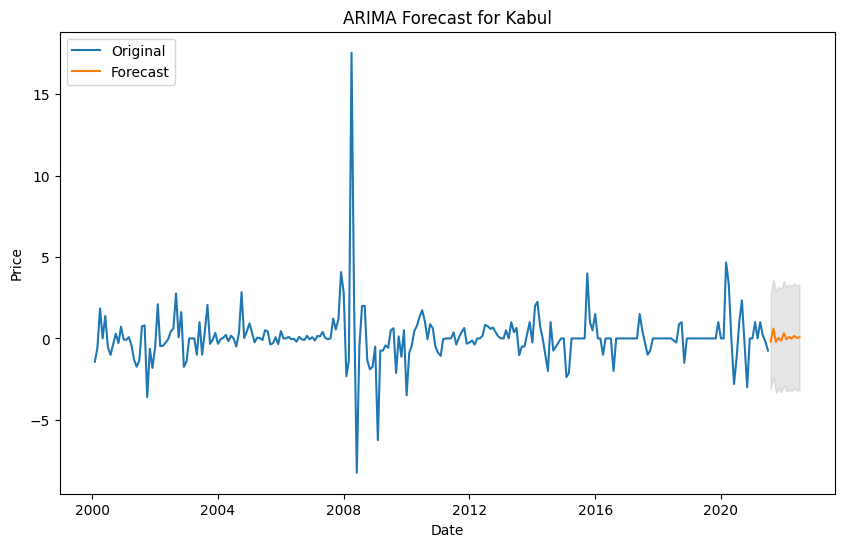

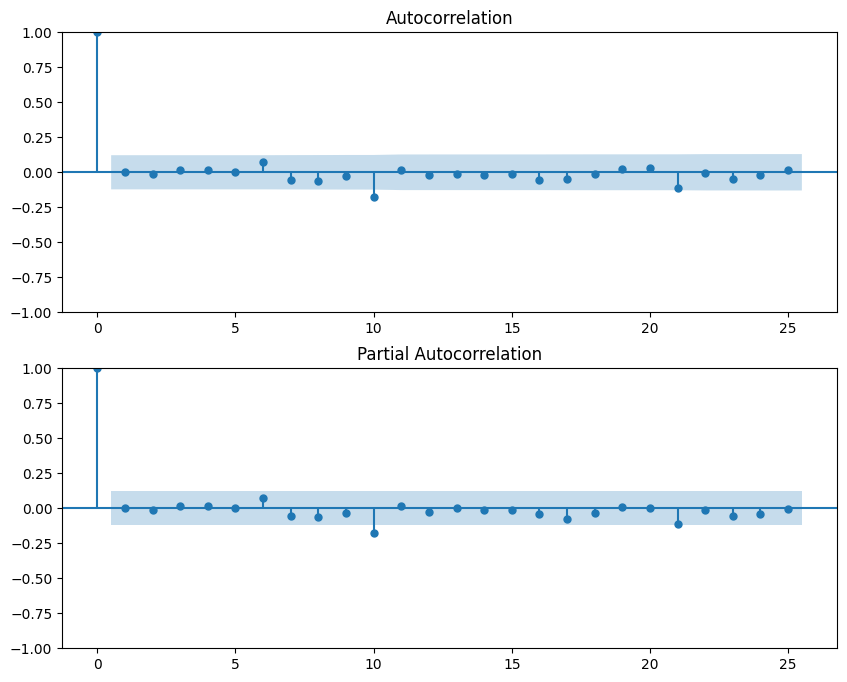

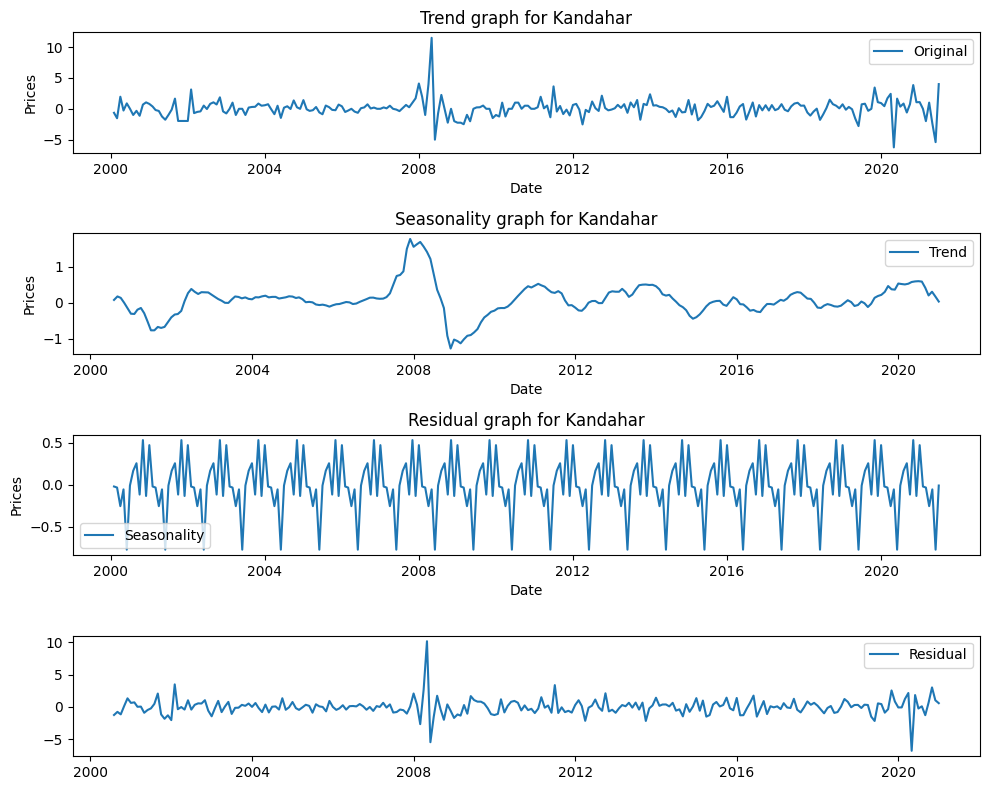

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=934.212, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=934.128, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=936.112, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=936.111, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=937.370, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=935.474, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.704 seconds
**************************** P,D,Q values for Kandahar************************


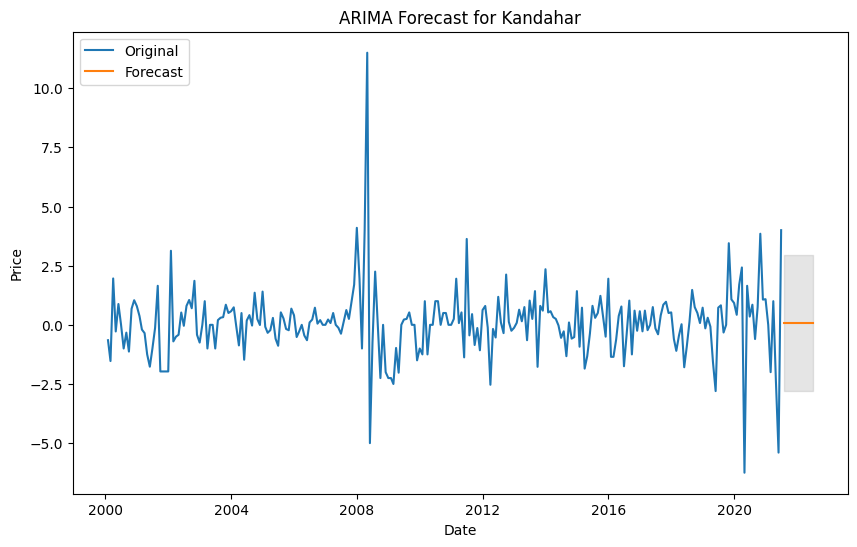

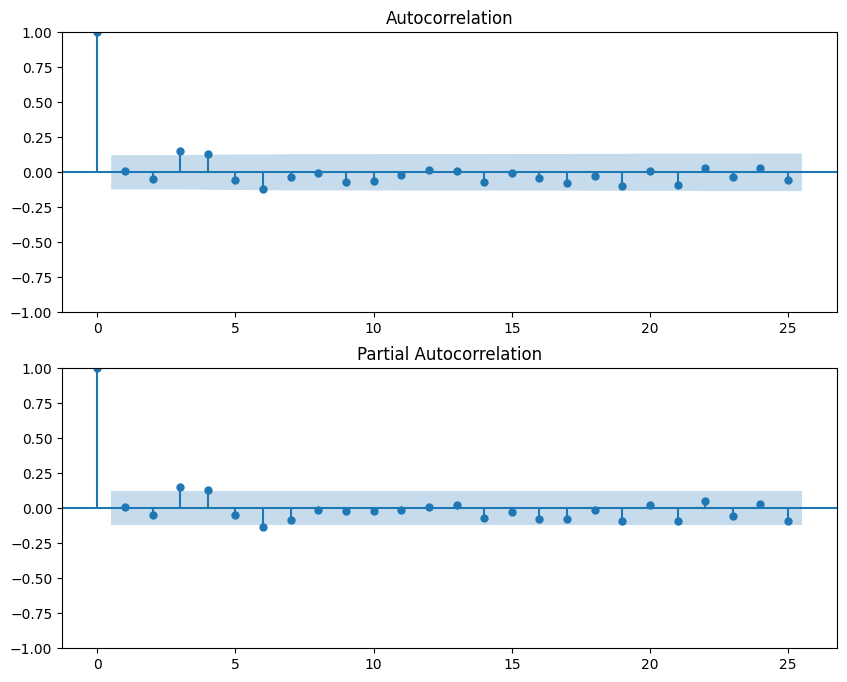

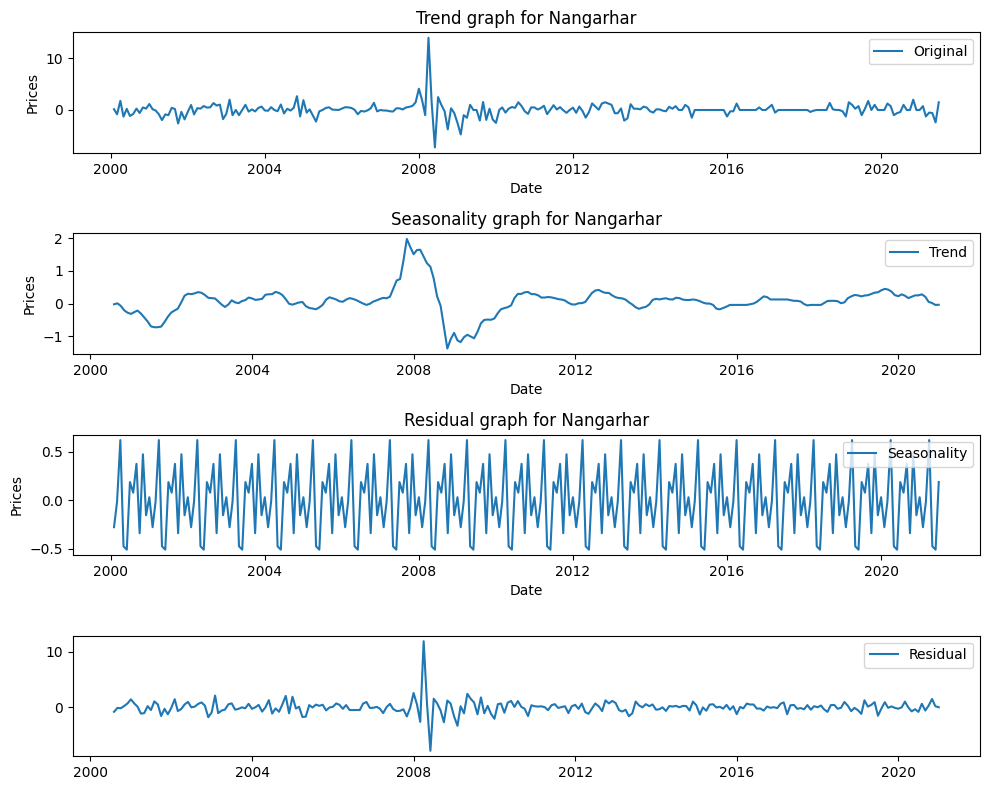

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=896.357, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=900.797, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=902.612, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=902.550, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=896.372, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=895.198, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=897.125, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=901.024, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=887.159, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=886.567, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=886.933, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=888.891, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=888.209, Time=0.10 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.174 seconds
**************************** P,D,Q 

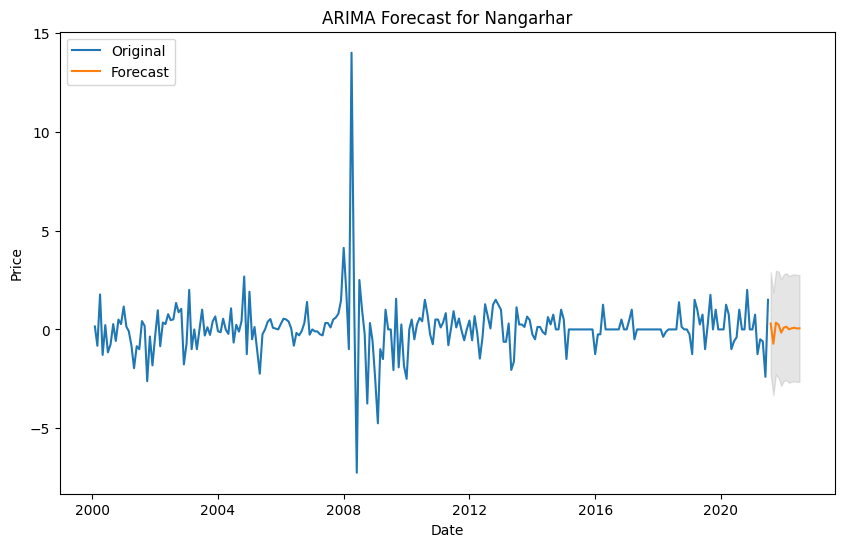

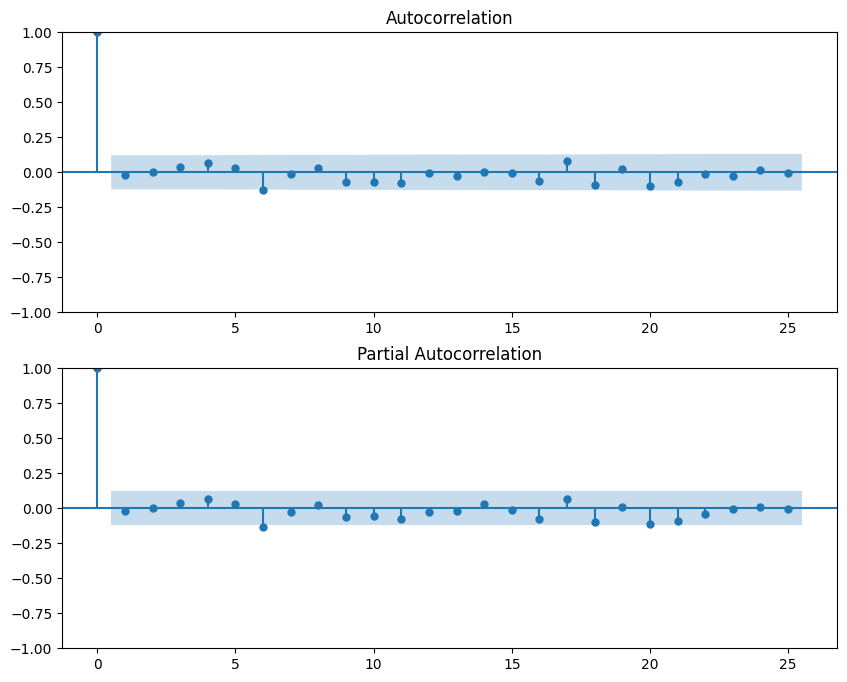

Dickey-Fuller test results for Badakhshan:
Time Period: 2003-02-01 00:00:00 to 2021-07-01 00:00:00
ADF Statistic: -5.918994843950219
p-value: 2.532684528883523e-07
Critical Values:
	1%: -3.461136478222043
	5%: -2.875078880098608
	10%: -2.5739861168199027

 Data is Stationary
****************************************************************
Dickey-Fuller test results for Daykundi:
Time Period: 2006-09-01 00:00:00 to 2021-07-01 00:00:00
ADF Statistic: -10.182370890508523
p-value: 6.643070171222193e-18
Critical Values:
	1%: -3.467631519151906
	5%: -2.8779183721695567
	10%: -2.575501353364474

 Data is Stationary
****************************************************************
Dickey-Fuller test results for Faryab:
Time Period: 2004-04-01 00:00:00 to 2021-07-01 00:00:00
ADF Statistic: -8.864422323383101
p-value: 1.453391076084529e-14
Critical Values:
	1%: -3.462818103072159
	5%: -2.8758145932936805
	10%: -2.574378674548251

 Data is Stationary
***********************************************

In [35]:
# Create an empty dictionary to store the test results for each province
test_results = {}

# Set the figure size
plt.figure(figsize=(20, 6))

# Iterate over each province
for province in province_dates.index:

    province_df = df_afghan_province[df_afghan_province['province_name'] == province].drop('province_name', axis=1)
    province_df = province_df.set_index(pd.to_datetime(province_df['date'])).asfreq('MS').drop('date', axis=1)
    province_df = province_df.interpolate()

    # Apply differencing to make the time series stationary
    province_df = province_df['price'].diff().dropna()

    # Perform seasonal decomposition
    decomposition = sm.tsa.seasonal_decompose(province_df, model='additive')

    # Extract the trend, seasonality, and residual components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot the decomposed components
    plt.figure(figsize=(10, 8))

    # Plot the Original component
    plt.title(f'Original graph for {province}')
    plt.xlabel('Date')
    plt.ylabel('Prices')
    plt.subplot(4, 1, 1)
    plt.plot(province_df, label='Original')
    plt.legend(loc='best')

    # Plot the trend component
    plt.title(f'Trend graph for {province}')
    plt.xlabel('Date')
    plt.ylabel('Prices')
    plt.subplot(4, 1, 2)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')

    # Plot the Seasonality component
    plt.title(f'Seasonality graph for {province}')
    plt.xlabel('Date')
    plt.ylabel('Prices')
    plt.subplot(4, 1, 3)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='best')

    # Plot the Residual component
    plt.title(f'Residual graph for {province}')
    plt.xlabel('Date')
    plt.ylabel('Prices')
    plt.subplot(4, 1, 4)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()
    # # Save the plot to the specific folder
    # file_path = os.path.join(output_dir, f'decompose_{province}_plots.png') 
    # plt.savefig(file_path)
    # plt.close()

    # Use auto_arima to automatically determine the optimal p, d, and q values
    model_arima = auto_arima(province_df, seasonal=False, trace=True)

    # Print the summary of the selected model
    print(f"**************************** P,D,Q values for {province}************************")
    #print(model_arima.summary())

    # Get the optimal p, d, q values
    p, d, q = model_arima.order

    # Fit the ARIMA model with the optimal p, d, q values obtained from auto_arima
    model_fit = ARIMA(province_df, order=(p, d, q)).fit()

    # Forecast for the next 12 months
    forecast = model_fit.get_forecast(steps=12)

    # Get the forecasted values and the associated confidence intervals
    forecast_values = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Check the residuals
    residuals = model_fit.resid

    # Plot the forecasted values and the original data with 80% confidence interval
    plt.figure(figsize=(10, 6))
    plt.plot(province_df, label='Original')
    plt.plot(forecast_values, label='Forecast')
    plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)
    # Plot the confidence intervals

    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'ARIMA Forecast for {province}')
    plt.show()
    # # Save the plot to the specific folder
    # file_path = os.path.join(output_dir, f'arima_plot_{province}.png') 
    # plt.savefig(file_path)
    # plt.close()

    # Plot the ACF and PACF of the residuals
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    plot_acf(residuals, ax=ax[0])
    plot_pacf(residuals, ax=ax[1])
    plt.show()
    # # Save the plot to the specific folder
    # file_path = os.path.join(output_dir, f'acf_pacf_{province}_plots.png') 
    # plt.savefig(file_path)
    # plt.close()

    
    # Perform the Dickey-Fuller test on the price column of the province DataFrame
    result = adfuller(province_df)
    
    # Store the test results in the dictionary
    test_results[province] = {
        'Min Date': province_df.index.min(),
        'Max Date': province_df.index.max(),
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }

# Print the test results for each province
for province, results in test_results.items():
    print(f"Dickey-Fuller test results for {province}:")
    print(f"Time Period: {results['Min Date']} to {results['Max Date']}")
    print(f"ADF Statistic: {results['ADF Statistic']}")
    print(f"p-value: {results['p-value']}")
    print("Critical Values:")
    for key, value in results['Critical Values'].items():
        print(f"\t{key}: {value}")
    print()
    if results['p-value']>0.05:
        print(" Data is not Stationary")
    else:
        print(" Data is Stationary")
    print("****************************************************************")


In [36]:
# Calculate the absolute error
absolute_error = np.abs(residuals)

# Calculate the squared error
squared_error = np.square(residuals)

# Calculate the percentage error
percentage_error = ((residuals) / province_df) * 100

# Calculate the mean absolute error (MAE)
mae = np.mean(absolute_error)

# Calculate the mean squared error (MSE)
mse = np.mean(squared_error)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Print the error metrics
print("MAE:", mae*100)
print("MSE:", mse*100)
print("RMSE:", rmse*100)


MAE: 74.9875475405288
MSE: 176.07198874202317
RMSE: 132.69212061837854


- To conclude for question 1 :
- The overall trend of the average prices of wheat – retail is increasing over time in Afghanistan. It shows a clear upward trend and follows an additive seasonality

- To conclude for question 3:
- Random Variability: Random fluctuations and noise in the data can introduce uncertainty into the forecast. These fluctuations may arise from various factors that are difficult to predict or control.
- External Factors: Forecasts can be influenced by external factors that are difficult to predict, such as changes in market conditions, economic trends, policy changes, or unforeseen events (e.g., natural disasters, political upheavals)
- ARIMA models make certain assumptions about the data, such as stationarity and the absence of outliers. If these assumptions are not met, it can introduce uncertainty into the forecast. Model selection and parameter estimation also involve some level of uncertainty
- The accuracy and completeness of historical data used for training the ARIMA model can affect the forecast uncertainty. Incomplete or unreliable data, data gaps, or changes in data collection methods can introduce uncertainty in the model's ability to capture underlying patterns and make accurate predictions.

- One approach to estimating confidence intervals in ARIMA forecasting is to use bootstrap resampling. This involves generating multiple resamples from the historical data, fitting ARIMA models to each resample, and obtaining a distribution of future forecasts. From this distribution, you can calculate the confidence intervals based on desired confidence levels (e.g., 90%, 95%). 

In [37]:
# Bootstrap resampling Set the number of bootstrap resamples
num_resamples = 100

# Create an empty DataFrame to store resampled forecasts
resampled_forecasts = pd.DataFrame()

# Perform bootstrap resampling and generate forecasts
for i in range(num_resamples):
    # Randomly sample with replacement from the original data
    resample = province_df.sample(n=len(province_df), replace=True)
    
    # Fit ARIMA model to the resampled data
    model = ARIMA(resample, order=(p, d, q))
    model_fit = model.fit()
    
    # Forecast the next 12 months
    forecast = model_fit.forecast(steps=12)
    
    # Store the resampled forecast
    resampled_forecasts[i] = forecast

# Calculate the mean forecast
mean_forecast = resampled_forecasts.mean(axis=1)

# Calculate the confidence intervals (e.g., 90% confidence level)
lower_bound = resampled_forecasts.quantile(0.05, axis=1)
upper_bound = resampled_forecasts.quantile(0.95, axis=1)

# Print the mean forecast and confidence intervals
print("Mean Forecast:")
print(mean_forecast)
print("\nConfidence Intervals:")
print(lower_bound)
print(upper_bound)


Mean Forecast:
258   0.04843
259   0.04879
260   0.05552
261   0.05556
262   0.05561
263   0.05645
264   0.05601
265   0.05584
266   0.05591
267   0.05592
268   0.05593
269   0.05594
dtype: float64

Confidence Intervals:
258   -0.11745
259   -0.11310
260   -0.09424
261   -0.04669
262   -0.06843
263   -0.05244
264   -0.06154
265   -0.05656
266   -0.05915
267   -0.05799
268   -0.05864
269   -0.05832
Name: 0.05, dtype: float64
258   0.20441
259   0.25219
260   0.19251
261   0.17778
262   0.17940
263   0.18332
264   0.18137
265   0.18147
266   0.18072
267   0.18089
268   0.18089
269   0.18094
Name: 0.95, dtype: float64
